---
# About this Notebook:

We will be exploring `statistical` and `machine learning` models to come up with a best estimator for hospitalisation bill.<br>
We will subsequently be reviewing the models' performance using mainly R2 score, with MAPE score.<br>
The target performance is R2 score>90%, and MAPE <10%.<br>
The model will also be used to identify important features that helps estimate hospital bills.<br>
Here is a summary of the modelling workflow you will see in this notebook:<br>
![](../images/model_approach.jpg)
---

# Part 1: Imports

## Import Libraries

In [1]:
import numpy as np # for mathematical computations
import pandas as pd # for data processing, analysis

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#Visualisation:
import seaborn               as sns
import matplotlib.pyplot     as plt
sns.set_theme(style="whitegrid")

#Functions for quick data analysis
from data_analysis import *

#Models:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV 
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

#Pre-modelling processing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder

#Model metrics:
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer, r2_score

#Hyperparameter tuning:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

#For importing/exporting data structures:
import pickle

## Import Data

In [2]:
df = pd.read_csv("../data_output/cleaned_df")

In [3]:
df_summary(df,'CLEANED DATASET')

Dataframe (CLEANED DATASET) Summary
Shape(col,rows): (3400, 38)
Number of duplicates: 0
------------------------------------------------------------
Number of each unique datatypes:
int64      24
object      7
float64     7
dtype: int64
------------------------------------------------------------
Columns with missing values:
--No Missing Data--
------------------------------------------------------------
Check Quantitative data values:
                      Column Name  Minimum Value  Maximum Value
0                 total_hosp_bill    2946.100354   98723.854994
1               medical_history_1       0.000000       1.000000
2               medical_history_2       0.000000       1.000000
3               medical_history_3       0.000000       1.000000
4               medical_history_4       0.000000       1.000000
5               medical_history_5       0.000000       1.000000
6               medical_history_6       0.000000       1.000000
7               medical_history_7       0.000000

**COMMENTS**
- No missing data
- No duplicated data
- Appropriate data types for use later

## Import Lists

Lists of column names for data feature filtering later
- `quantitative_col`: Quantitative features
- `categorical_col`: Categorical features
- `subset_col_1`: Exclude categorical features where there is no significant hospital bills between the classes
- `subset_col_2`: Exclude categorical features where there is no significant hospital bills between the classes AND quantitative features showed poor correlation (|r|<0.3) with hospital bill

In [4]:
# Specify the file path where you want to save the dictionary
file_path_1 = '../data_output/subset_col_1_list.pkl'
file_path_2 = '../data_output/subset_col_2_list.pkl'
file_path_3 = '../data_output/qty_col_list.pkl'
file_path_4 = '../data_output/categorical_col_list.pkl'


# Load the list from the file using pickle
with open(file_path_1, 'rb') as file:
    subset_col_1 = pickle.load(file)
with open(file_path_2, 'rb') as file:
    subset_col_2 = pickle.load(file)
with open(file_path_3, 'rb') as file:
    quantitative_col = pickle.load(file)
with open(file_path_4, 'rb') as file:
    categorical_col = pickle.load(file)

In [5]:
len(quantitative_col)
quantitative_col

12

['total_hosp_bill',
 'Age_upon_admission',
 'hospitalization_duration_days',
 'sum_medical_history',
 'sum_symptoms',
 'sum_medications',
 'lab_result_1',
 'lab_result_2',
 'lab_result_3',
 'weight',
 'height',
 'BMI']

In [6]:
len(categorical_col)
categorical_col

22

['gender',
 'race',
 'resident_status',
 'had_prev_admission',
 'medical_history_1',
 'medical_history_2',
 'medical_history_3',
 'medical_history_4',
 'medical_history_5',
 'medical_history_6',
 'medical_history_7',
 'preop_medication_1',
 'preop_medication_2',
 'preop_medication_3',
 'preop_medication_4',
 'preop_medication_5',
 'preop_medication_6',
 'symptom_1',
 'symptom_2',
 'symptom_3',
 'symptom_4',
 'symptom_5']

In [7]:
len(subset_col_1)
subset_col_1

18

['Age_upon_admission',
 'hospitalization_duration_days',
 'sum_medical_history',
 'sum_symptoms',
 'sum_medications',
 'BMI',
 'gender',
 'medical_history_1',
 'medical_history_6',
 'preop_medication_2',
 'preop_medication_6',
 'race',
 'resident_status',
 'symptom_1',
 'symptom_2',
 'symptom_3',
 'symptom_4',
 'symptom_5']

In [8]:
len(subset_col_2)
subset_col_2

14

['gender',
 'medical_history_1',
 'medical_history_6',
 'preop_medication_2',
 'preop_medication_6',
 'race',
 'resident_status',
 'symptom_1',
 'symptom_2',
 'symptom_3',
 'symptom_4',
 'symptom_5',
 'Age_upon_admission',
 'sum_symptoms']

---
# Part 2: Creating multiple data sets

## 2.1 Train-test-split

In [9]:
unwanted_col = ['total_hosp_bill','patient_id', 'date_of_admission', 'date_of_discharge','date_of_birth','weight','height']

#establishing X and y
X = df.drop(columns = unwanted_col)
y = df['total_hosp_bill']

#perform train_test_split (70:30)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=23)
for i in X_train, X_test, y_train, y_test:
    i.reset_index(inplace=True, drop=True)

In [10]:
#Features:
X_train.columns.tolist()

['medical_history_1',
 'medical_history_2',
 'medical_history_3',
 'medical_history_4',
 'medical_history_5',
 'medical_history_6',
 'medical_history_7',
 'preop_medication_1',
 'preop_medication_2',
 'preop_medication_3',
 'preop_medication_4',
 'preop_medication_5',
 'preop_medication_6',
 'symptom_1',
 'symptom_2',
 'symptom_3',
 'symptom_4',
 'symptom_5',
 'lab_result_1',
 'lab_result_2',
 'lab_result_3',
 'gender',
 'race',
 'resident_status',
 'Age_upon_admission',
 'hospitalization_duration_days',
 'had_prev_admission',
 'BMI',
 'sum_medical_history',
 'sum_symptoms',
 'sum_medications']

## 2.2 Increase training data size

**STEP 1 - create sets of indices using sampling with replacement**

In [11]:
#Using X_train indices, to create sets of indices using sampling with replacement
original_data_size = len(X_train)
indices_twofold = list(np.random.choice(range(original_data_size), size=original_data_size*2, replace=True))
len(indices_twofold)

5100

In [12]:
indices_fourfold = list(np.random.choice(range(original_data_size), size=original_data_size*4, replace=True))
len(indices_fourfold)

10200

**STEP 2 - create bootstrapped datasets using the indices from earlier**

In [13]:
# Creating the bootstrap train data
X_train_2fold = X_train.iloc[indices_twofold]
X_train_4fold = X_train.iloc[indices_fourfold]
X_train_original = X_train.copy()

In [14]:
# Creating the bootstrap train data
y_train_2fold = y_train.iloc[indices_twofold]
y_train_4fold = y_train.iloc[indices_fourfold]
y_train_original = y_train.copy()

**STEP 3 - storing datasets in lists, & perform sanity check**

In [15]:
#List of training X dataset
X_train_data_ls = [X_train_original,X_train_2fold,X_train_4fold]

#List of training y dataset
y_train_data_ls = [y_train_original,y_train_2fold,y_train_4fold]

In [16]:
# Sanity Check on X datasets:
for X in X_train_data_ls:
    print(X.shape)

(2550, 31)
(5100, 31)
(10200, 31)


In [17]:
# Sanity Check on y datasets:
for y in y_train_data_ls:
    print(y.shape)

(2550,)
(5100,)
(10200,)


**STEP 3 - storing datasets in a dictionary**

In [18]:
X_name_ls = 'X_train_original,X_train_2fold,X_train_4fold'.split(',')
y_name_ls = 'y_train_original,y_train_2fold,y_train_4fold'.split(',')

In [19]:
X_train_dictionary = {k:v for k,v in zip(X_name_ls,X_train_data_ls)}
y_train_dictionary = {k:v for k,v in zip(y_name_ls,y_train_data_ls)}

In [20]:
list(y_train_dictionary.values()) == y_train_data_ls
list(X_train_dictionary.values()) == X_train_data_ls

True

True

**COMMENT**<br>

At this point:<br>
There is 3 sets of X train data (with different data size).<br>
There is 3 sets of y train data (with different data size).<br>
There is 1 set of X_test<br>
There is 1 set of y_test<br>
There is a `list` storing the X train data: `X_train_data_ls`<br>
There is a `list` storing the y train data: `y_train_data_ls`<br>
There is a `dictionary` storing the X train data: `X_train_dictionary` with 3 sets of X data<br>
There is a `dictionary` storing the y train data: `y_train_dictionary` with 3 sets of y data<br>

## 2.3 Creating diff features data subset

### Train dataset

In [21]:
name_ls_1 = 'X_train_original,X_train_2fold,X_train_4fold'.split(',')
name_ls_2 = ['allcol','sub1col','sub2col']
subsets = [[],subset_col_1,subset_col_2]
X_train_dictionary_2 = {}
for i in range(3):
    X_data = X_train_data_ls[i]
    for j in range(3):
        sizename = name_ls_1[i]
        colsetname = name_ls_2[j]
        df_name = f"{sizename}_{colsetname}"
        if j==0:
            globals()[df_name] = X_data.copy()
        else:
            globals()[df_name] = X_data.loc[:,subsets[j]]
        print(f"{df_name} created")
        print(globals()[df_name].shape)
        X_train_dictionary_2[df_name] = globals()[df_name]

X_train_original_allcol created
(2550, 31)
X_train_original_sub1col created
(2550, 18)
X_train_original_sub2col created
(2550, 14)
X_train_2fold_allcol created
(5100, 31)
X_train_2fold_sub1col created
(5100, 18)
X_train_2fold_sub2col created
(5100, 14)
X_train_4fold_allcol created
(10200, 31)
X_train_4fold_sub1col created
(10200, 18)
X_train_4fold_sub2col created
(10200, 14)


In [22]:
for k,v in X_train_dictionary_2.items():
    print(k, v.shape)

X_train_original_allcol (2550, 31)
X_train_original_sub1col (2550, 18)
X_train_original_sub2col (2550, 14)
X_train_2fold_allcol (5100, 31)
X_train_2fold_sub1col (5100, 18)
X_train_2fold_sub2col (5100, 14)
X_train_4fold_allcol (10200, 31)
X_train_4fold_sub1col (10200, 18)
X_train_4fold_sub2col (10200, 14)


In [23]:
#update `X_train_data_ls`
X_train_data_ls = []
for v in X_train_dictionary_2.values():
    X_train_data_ls.append(v)

In [24]:
list(X_train_dictionary_2.values()) == X_train_data_ls

True

### Test dataset

In [25]:
name_ls_1 = 'X_test_original,X_test_2fold,X_test_4fold'.split(',')
name_ls_2 = ['allcol','sub1col','sub2col']
subsets = [[],subset_col_1,subset_col_2]
X_test_data_ls = []
X_test_dictionary = {}

X_data = X_test

for i in range(3):
    for j in range(3):
        sizename = name_ls_1[i]
        colsetname = name_ls_2[j]
        df_name = f"{sizename}_{colsetname}"
        if j==0:
            globals()[df_name] = X_data.copy()
        else:
            globals()[df_name] = X_data.loc[:,subsets[j]]
        print(f"{df_name} created")
        print(globals()[df_name].shape)
        X_test_data_ls.append(globals()[df_name])     
        X_test_dictionary[df_name] = globals()[df_name]

X_test_original_allcol created
(850, 31)
X_test_original_sub1col created
(850, 18)
X_test_original_sub2col created
(850, 14)
X_test_2fold_allcol created
(850, 31)
X_test_2fold_sub1col created
(850, 18)
X_test_2fold_sub2col created
(850, 14)
X_test_4fold_allcol created
(850, 31)
X_test_4fold_sub1col created
(850, 18)
X_test_4fold_sub2col created
(850, 14)


In [26]:
for k,v in X_test_dictionary.items():
    print(k, v.shape)

X_test_original_allcol (850, 31)
X_test_original_sub1col (850, 18)
X_test_original_sub2col (850, 14)
X_test_2fold_allcol (850, 31)
X_test_2fold_sub1col (850, 18)
X_test_2fold_sub2col (850, 14)
X_test_4fold_allcol (850, 31)
X_test_4fold_sub1col (850, 18)
X_test_4fold_sub2col (850, 14)


In [27]:
list(X_test_dictionary.values()) == X_test_data_ls

True

**COMMENT**<br>

At this point:<br>
There is 1 set of y_test<br>
There is 3 sets of y train data (with different data size).<br>
There is 9 sets of X train data (with different data size AND column set).<br>
 There is 9 data but 3 unique sets of X test data<br>
- 3 unique data sets with different column set<br>
- Created 3 extra 3 as they will be encoded/scaled differently later, creating unique X test data for each X train data<br>

There is a `list` storing the X train data: `X_train_data_ls` with 9 X sets<br>
There is a `list` storing the X test data: `X_test_data_ls` with 9 X sets<br>
There is a `list` storing the y train data: `y_train_data_ls` with 9 y sets<br><br>
There is a `dictionary` storing the X train data: `X_train_dictionary_2` with 9 sets of X data<br>
There is a `dictionary` storing the X test data: `X_test_dictionary` with 9 sets of X data <br>
There is a `dictionary` storing the y train data: `y_train_dictionary` with 3 sets of y data<br><br>
There is a `dictionary` storing the X train data: `X_train_dictionary` with 3 initial sets of X data (*for reference if needed*) <br>


---
# Part 3: Model-preprocessing

- scaling
- encoding

In [28]:
def onehotenc_df (train,test):
    enc = OneHotEncoder(drop = 'first', handle_unknown = 'ignore')
    train = enc.fit_transform(train)
    test = enc.transform(test)
    
    output_col_names = list(enc.get_feature_names_out())
    train_df = pd.DataFrame(train.toarray(), columns = output_col_names)
    test_df = pd.DataFrame(test.toarray(), columns = output_col_names)
    return (train_df,test_df,enc)

def robustscaler_df (train,test):
    rs = RobustScaler()
    train = rs.fit_transform(train)
    test = rs.transform(test)
    
    output_col_names = list(rs.get_feature_names_out())
    train_df = pd.DataFrame(train, columns = output_col_names)
    test_df = pd.DataFrame(test, columns = output_col_names)
    return (train_df,test_df,rs)

In [29]:
#Create empty dictionary to store the transformers
encoders_dict = {}
scalers_dict = {}
X_train_name_ls = list(X_train_dictionary_2.keys())
X_test_name_ls = list(X_test_dictionary.keys())


for i in range(9):
    train_df = X_train_data_ls[i]
    test_df = X_test_data_ls[i]
    X_train_name = X_train_name_ls[i]
    X_test_name = X_test_name_ls[i] 
    
    print(f"for Train: {X_train_name} & Test: {X_test_name}")
    print(f'Original train set shape:\n{train_df.shape}')
    print(f'Original test set shape:\n{test_df.shape}')
    
    #List to filter features by data type
    numerical_col = [col for col in train_df.columns if col in quantitative_col]
    cat_col = [col for col in train_df.columns if col in categorical_col]
    
    #Sanity Check
    accounted_col = numerical_col+cat_col
    if len(accounted_col) != len(train_df.columns):
        print(f"""
        ISSUE!
        Columns not address = {[col for col in train_df.columns if col not in accounted_col]}""")
        break
    
    #Seperating the data for different model-preprocessing
    train_numerical_df = train_df.loc[:,numerical_col]
    test_numerical_df = test_df.loc[:,numerical_col]
    
    train_cat_df = train_df.loc[:,cat_col]
    test_cat_df = test_df.loc[:,cat_col]
    
    #Setting the transformers names
    suffix_name = X_train_name_ls[i].replace("X_train", "")
    encoder_name = f"onehotenc{suffix_name}"
    scaler_name = f"robustscal{suffix_name}"   
    
    #Apply transformers
    train_cat_df, test_cat_df, globals()[encoder_name] = onehotenc_df (train_cat_df,test_cat_df)
    train_numerical_df, test_numerical_df, globals()[scaler_name] = robustscaler_df (train_numerical_df,test_numerical_df)
    
    X_train_data_ls[i] = pd.concat(objs = [train_cat_df,train_numerical_df], axis=1)
    X_test_data_ls[i] = pd.concat(objs = [test_cat_df,test_numerical_df], axis=1)
    
    #Update transformed dataframe
    X_train_dictionary_2[X_train_name] = X_train_data_ls[i]
    X_test_dictionary[X_test_name] = X_test_data_ls[i]
    
    #Update transformer dictionary
    encoders_dict[encoder_name] = globals()[encoder_name]
    scalers_dict[scaler_name] = globals()[scaler_name]
    
    print(f'Processed train set shape:\n{X_train_data_ls[i].shape}')
    print(f'Processed test set shape:\n{X_test_data_ls[i].shape}\n\n')

for Train: X_train_original_allcol & Test: X_test_original_allcol
Original train set shape:
(2550, 31)
Original test set shape:
(850, 31)
Processed train set shape:
(2550, 34)
Processed test set shape:
(850, 34)


for Train: X_train_original_sub1col & Test: X_test_original_sub1col
Original train set shape:
(2550, 18)
Original test set shape:
(850, 18)
Processed train set shape:
(2550, 21)
Processed test set shape:
(850, 21)


for Train: X_train_original_sub2col & Test: X_test_original_sub2col
Original train set shape:
(2550, 14)
Original test set shape:
(850, 14)
Processed train set shape:
(2550, 17)
Processed test set shape:
(850, 17)


for Train: X_train_2fold_allcol & Test: X_test_2fold_allcol
Original train set shape:
(5100, 31)
Original test set shape:
(850, 31)
Processed train set shape:
(5100, 34)
Processed test set shape:
(850, 34)


for Train: X_train_2fold_sub1col & Test: X_test_2fold_sub1col
Original train set shape:
(5100, 18)
Original test set shape:
(850, 18)
Processed tr

### Sanity Check

In [30]:
# There should be 9 encoders and 9 scalers
len(encoders_dict.keys())
len(scalers_dict.keys())

9

9

In [31]:
#view the names of the transfomer
list(encoders_dict.keys())
list(scalers_dict.keys())

['onehotenc_original_allcol',
 'onehotenc_original_sub1col',
 'onehotenc_original_sub2col',
 'onehotenc_2fold_allcol',
 'onehotenc_2fold_sub1col',
 'onehotenc_2fold_sub2col',
 'onehotenc_4fold_allcol',
 'onehotenc_4fold_sub1col',
 'onehotenc_4fold_sub2col']

['robustscal_original_allcol',
 'robustscal_original_sub1col',
 'robustscal_original_sub2col',
 'robustscal_2fold_allcol',
 'robustscal_2fold_sub1col',
 'robustscal_2fold_sub2col',
 'robustscal_4fold_allcol',
 'robustscal_4fold_sub1col',
 'robustscal_4fold_sub2col']

In [32]:
# allcol X data should have 34 col
# sub1col X data should have 21 col
# sub2col X data should have 17 col
for k,v in X_train_dictionary_2.items():
    print(k,v.shape)

X_train_original_allcol (2550, 34)
X_train_original_sub1col (2550, 21)
X_train_original_sub2col (2550, 17)
X_train_2fold_allcol (5100, 34)
X_train_2fold_sub1col (5100, 21)
X_train_2fold_sub2col (5100, 17)
X_train_4fold_allcol (10200, 34)
X_train_4fold_sub1col (10200, 21)
X_train_4fold_sub2col (10200, 17)


In [33]:
# allcol X data should have 34 col
# sub1col X data should have 21 col
# sub2col X data should have 17 col
for k,v in X_test_dictionary.items():
    print(k,v.shape)

X_test_original_allcol (850, 34)
X_test_original_sub1col (850, 21)
X_test_original_sub2col (850, 17)
X_test_2fold_allcol (850, 34)
X_test_2fold_sub1col (850, 21)
X_test_2fold_sub2col (850, 17)
X_test_4fold_allcol (850, 34)
X_test_4fold_sub1col (850, 21)
X_test_4fold_sub2col (850, 17)


In [34]:
# dict value and list should match
list(X_train_dictionary_2.values()) == X_train_data_ls

True

In [35]:
# dict value and list should match
list(X_test_dictionary.values()) == X_test_data_ls

True

**COMMENT**<br>

At this point:<br>
There is 1 set of y_test<br>
There is 3 sets of y train data (with different data size).<br>
There is 9 sets of X train data (with different data size AND column set).<br>
There is 9 sets of X test data (with different column set AND different transformers applied).<br>

There is a `list` storing the X train data: `X_train_data_ls` with 9 X sets<br>
There is a `list` storing the X test data: `X_test_data_ls` with 9 X sets<br>
There is a `list` storing the y train data: `y_train_data_ls` with 9 y sets<br><br>
There is a `dictionary` storing the X train data: `X_train_dictionary_2` with 9 sets of X data<br>
There is a `dictionary` storing the X test data: `X_test_dictionary` with 9 sets of X data <br>
There is a `dictionary` storing the y train data: `y_train_dictionary` with 3 sets of y data<br><br>
There is a `dictionary` storing the X train data: `X_train_dictionary` with 3 initial sets of X data (*for reference if needed*) <br>
There is a `dictionary` storing the X encoders: `encoders_dict`<br>
There is a `dictionary` storing the X scalers: `scalers_dict`

All 9 X train and X test data sets have been transformed for modelling

---
# Part 4: Statistical Models

## 4.1 Linear Regression

In [36]:
# Create an empty dataframe
lr_scores_df = pd.DataFrame(columns=['Model',
                                  'y_train',
                                  'y_test',
                                  'X_train',
                                  'X_test',
                                  'R2_train',
                                  'R2_test',
                                  'MAPE_train',
                                  'MAPE_test',
                                  'RMSE_train',                                  
                                  'RMSE_test'])
score_df_col = list(lr_scores_df.columns)

#Name list suffix:
suffix_ls = [i.replace("X_train", "") for i in list(X_train_dictionary_2.keys())]

#Create an empty dictionary:
models_dictionary = {}

for i in range(9):
    Xtrain = X_train_data_ls[i]
    Xtest = X_test_data_ls[i]
    Xtrain_name = list(X_train_dictionary_2.keys())[i]
    Xtest_name = list(X_test_dictionary.keys())[i]
    
    
    w = 0 if i < 3 else 2 if i > 5 else 1
    ytrain = y_train_data_ls[w]
    ytest = y_test
    ytrain_name = list(y_train_dictionary)[w]
    ytest_name = 'original y_test'
    

    #Model Name
    model_name = f"Linear_Regression_{suffix_ls[i]}"
    #Model fitting
    model = LinearRegression()
    model.fit(Xtrain, ytrain)
    globals()[model_name] = model
    #Update model dictionary
    models_dictionary[model_name] = model

    #Metric scores
    ytrain_pred = model.predict(Xtrain)
    ytest_pred = model.predict(Xtest)
    
    r2_score_train = model.score(Xtrain, ytrain).round(5)
    mape_score_train = mean_absolute_percentage_error(ytrain, ytrain_pred).round(5)
    rmse_score_train = mean_squared_error(ytrain, ytrain_pred, squared=False).round(5)

    
    r2_score_test = model.score(Xtest, ytest).round(5)
    mape_score_test = mean_absolute_percentage_error(ytest, ytest_pred).round(5)
    rmse_score_test = mean_squared_error(ytest, ytest_pred, squared=False).round(5)
    
    # Append scores to the dataframe
    new_append = [model_name,
           ytrain_name,
           ytest_name,
           Xtrain_name,
           Xtest_name,
           r2_score_train,
           r2_score_test,
           mape_score_train,
           mape_score_test,
           rmse_score_train,
           rmse_score_test]
    lr_scores_df = pd.concat([lr_scores_df,
                           pd.DataFrame({k:v for k,v in zip (score_df_col,new_append)},
                                        index=[0])],
                          ignore_index=True)
lr_scores_df

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

,Model,y_train,y_test,X_train,X_test,R2_train,R2_test,MAPE_train,MAPE_test,RMSE_train,RMSE_test
0,Linear_Regression__original_allcol,y_train_original,original y_test,X_train_original_allcol,X_test_original_allcol,0.92344,0.93352,0.09779,0.09946,2916.87472,2290.22037
1,Linear_Regression__original_sub1col,y_train_original,original y_test,X_train_original_sub1col,X_test_original_sub1col,0.92250,0.93184,0.09890,0.09990,2934.60471,2319.03683
2,Linear_Regression__original_sub2col,y_train_original,original y_test,X_train_original_sub2col,X_test_original_sub2col,0.90373,0.90263,0.11283,0.11871,3270.87040,2771.79742
3,Linear_Regression__2fold_allcol,y_train_2fold,original y_test,X_train_2fold_allcol,X_test_2fold_allcol,0.91971,0.93449,0.10032,0.10097,2963.45199,2273.49997
4,Linear_Regression__2fold_sub1col,y_train_2fold,original y_test,X_train_2fold_sub1col,X_test_2fold_sub1col,0.91932,0.93375,0.10083,0.10096,2970.72238,2286.37028
5,Linear_Regression__2fold_sub2col,y_train_2fold,original y_test,X_train_2fold_sub2col,X_test_2fold_sub2col,0.90051,0.90378,0.11501,0.11989,3298.85839,2755.39328
6,Linear_Regression__4fold_allcol,y_train_4fold,original y_test,X_train_4fold_allcol,X_test_4fold_allcol,0.92118,0.93383,0.10009,0.09906,2966.37243,2284.85175
7,Linear_Regression__4fold_sub1col,y_train_4fold,original y_test,X_train_4fold_sub1col,X_test_4fold_sub1col,0.92013,0.93236,0.10122,0.09939,2986.09594,2310.09408
8,Linear_Regression__4fold_sub2col,y_train_4fold,original y_test,X_train_4fold_sub2col,X_test_4fold_sub2col,0.90054,0.90305,0.11592,0.11806,3332.17760,2765.74843


In [37]:
list(models_dictionary.keys())

['Linear_Regression__original_allcol',
 'Linear_Regression__original_sub1col',
 'Linear_Regression__original_sub2col',
 'Linear_Regression__2fold_allcol',
 'Linear_Regression__2fold_sub1col',
 'Linear_Regression__2fold_sub2col',
 'Linear_Regression__4fold_allcol',
 'Linear_Regression__4fold_sub1col',
 'Linear_Regression__4fold_sub2col']

**Remarks**
The simplest model `Linear Regression` using all the original datasize and columns performs well without overfittin, with test R2 score of 93%.

**COMMENT**<br>

At this point:<br>
There is 1 set of y_test<br>
There is 3 sets of y train data (with different data size).<br>
There is 9 sets of X train data (with different data size AND column set).<br>
There is 9 sets of X test data (with different column set AND different transformers applied).<br>

There is a `list` storing the X train data: `X_train_data_ls` with 9 X sets<br>
There is a `list` storing the X test data: `X_test_data_ls` with 9 X sets<br>
There is a `list` storing the y train data: `y_train_data_ls` with 9 y sets<br><br>
There is a `dictionary` storing the X train data: `X_train_dictionary_2` with 9 sets of X data<br>
There is a `dictionary` storing the X test data: `X_test_dictionary` with 9 sets of X data <br>
There is a `dictionary` storing the y train data: `y_train_dictionary` with 3 sets of y data<br><br>
There is a `dictionary` storing the X train data: `X_train_dictionary` with 3 initial sets of X data (*for reference if needed*) <br>

All 9 X train and X test data sets have been transformed for modelling

*Transformers*
There is a `dictionary` storing the X encoders: `encoders_dict`<br>
There is a `dictionary` storing the X scalers: `scalers_dict`<br>
There is a `dictionary` storing the fitted models: `models_dictionary` with 9 `Linear Regression` models<br>

## 4.2 Penalized Regression

In [38]:
%%time
model_types = ['Lasso', 'Ridge', 'ElasticNet']
alphas = np.logspace(-2,2,100)
l1_ratio = np.arange(0.1,1,0.1)
progress = 1

# Create an empty dataframe
pen_reg_scores_df = pd.DataFrame(columns=['Model',
                                  'y_train',
                                  'y_test',
                                  'X_train',
                                  'X_test',
                                  'R2_train',
                                  'R2_test',
                                  'MAPE_train',
                                  'MAPE_test',
                                  'RMSE_train',                                  
                                  'RMSE_test'])
score_df_col = list(pen_reg_scores_df.columns)

#Name list suffix:
suffix_ls = [i.replace("X_train", "") for i in list(X_train_dictionary_2.keys())]


for m_type in range(len(model_types)):

    
    for i in range(9):
        print(f'Progress {progress}/27')
        progress = progress + 1
        
        Xtrain = X_train_data_ls[i]
        Xtest = X_test_data_ls[i]
        Xtrain_name = list(X_train_dictionary_2.keys())[i]
        Xtest_name = list(X_test_dictionary.keys())[i]


        w = 0 if i < 3 else 2 if i > 5 else 1
        ytrain = y_train_data_ls[w]
        ytest = y_test
        ytrain_name = list(y_train_dictionary)[w]
        ytest_name = 'original y_test'


        #Model Name
        model_name = f"{model_types[m_type]}{suffix_ls[i]}"
        #Model fitting
        if m_type == 0:
            my_model = LassoCV(max_iter=10000,
                               alphas = alphas)
        elif m_type ==1:
            my_model = RidgeCV(alphas = alphas)

        elif m_type ==2:
            my_model = ElasticNetCV(max_iter=10000,
                                    alphas = alphas,
                                    l1_ratio = l1_ratio)
        my_model.fit(Xtrain, ytrain)
        globals()[model_name] = my_model
        #Update model dictionary
        models_dictionary[model_name] = my_model

        #Metric scores
        ytrain_pred = my_model.predict(Xtrain)
        ytest_pred = my_model.predict(Xtest)

        r2_score_train = my_model.score(Xtrain, ytrain).round(5)
        mape_score_train = mean_absolute_percentage_error(ytrain, ytrain_pred).round(5)
        rmse_score_train = mean_squared_error(ytrain, ytrain_pred, squared=False).round(5)


        r2_score_test = my_model.score(Xtest, ytest).round(5)
        mape_score_test = mean_absolute_percentage_error(ytest, ytest_pred).round(5)
        rmse_score_test = mean_squared_error(ytest, ytest_pred, squared=False).round(5)

        # Append scores to the dataframe
        new_append = [model_name,
               ytrain_name,
               ytest_name,
               Xtrain_name,
               Xtest_name,
               r2_score_train,
               r2_score_test,
               mape_score_train,
               mape_score_test,
               rmse_score_train,
               rmse_score_test]
        pen_reg_scores_df = pd.concat([pen_reg_scores_df,
                               pd.DataFrame({k:v for k,v in zip (score_df_col,new_append)},
                                            index=[0])],
                              ignore_index=True)
pen_reg_scores_df

Progress 1/27
Progress 2/27
Progress 3/27
Progress 4/27
Progress 5/27
Progress 6/27
Progress 7/27
Progress 8/27
Progress 9/27
Progress 10/27
Progress 11/27
Progress 12/27
Progress 13/27
Progress 14/27
Progress 15/27
Progress 16/27
Progress 17/27
Progress 18/27
Progress 19/27
Progress 20/27
Progress 21/27
Progress 22/27
Progress 23/27
Progress 24/27
Progress 25/27
Progress 26/27
Progress 27/27
CPU times: total: 8.64 s
Wall time: 8.99 s


,Model,y_train,y_test,X_train,X_test,R2_train,R2_test,MAPE_train,MAPE_test,RMSE_train,RMSE_test
0,Lasso_original_allcol,y_train_original,original y_test,X_train_original_allcol,X_test_original_allcol,0.92345,0.93391,0.09734,0.09914,2916.67844,2283.58485
1,Lasso_original_sub1col,y_train_original,original y_test,X_train_original_sub1col,X_test_original_sub1col,0.92248,0.93281,0.09818,0.09907,2934.98746,2302.42571
2,Lasso_original_sub2col,y_train_original,original y_test,X_train_original_sub2col,X_test_original_sub2col,0.90371,0.90331,0.11237,0.11826,3271.11001,2762.07388
3,Lasso_2fold_allcol,y_train_2fold,original y_test,X_train_2fold_allcol,X_test_2fold_allcol,0.92026,0.93558,0.09965,0.10013,2953.29280,2254.53067
4,Lasso_2fold_sub1col,y_train_2fold,original y_test,X_train_2fold_sub1col,X_test_2fold_sub1col,0.91932,0.93395,0.10070,0.10077,2970.71135,2282.80189
5,Lasso_2fold_sub2col,y_train_2fold,original y_test,X_train_2fold_sub2col,X_test_2fold_sub2col,0.90052,0.90394,0.11497,0.11985,3298.64200,2753.04491
6,Lasso_4fold_allcol,y_train_4fold,original y_test,X_train_4fold_allcol,X_test_4fold_allcol,0.92118,0.93406,0.09984,0.09883,2966.32151,2280.88374
7,Lasso_4fold_sub1col,y_train_4fold,original y_test,X_train_4fold_sub1col,X_test_4fold_sub1col,0.92015,0.93269,0.10068,0.09886,2985.59467,2304.47118
8,Lasso_4fold_sub2col,y_train_4fold,original y_test,X_train_4fold_sub2col,X_test_4fold_sub2col,0.90055,0.90319,0.11552,0.11758,3331.95163,2763.73304
9,Ridge_original_allcol,y_train_original,original y_test,X_train_original_allcol,X_test_original_allcol,0.92346,0.93362,0.09763,0.09952,2916.49625,2288.49554


In [ ]:
list(models_dictionary.keys())

['Linear_Regression__original_allcol',
 'Linear_Regression__original_sub1col',
 'Linear_Regression__original_sub2col',
 'Linear_Regression__2fold_allcol',
 'Linear_Regression__2fold_sub1col',
 'Linear_Regression__2fold_sub2col',
 'Linear_Regression__4fold_allcol',
 'Linear_Regression__4fold_sub1col',
 'Linear_Regression__4fold_sub2col',
 'Lasso_original_allcol',
 'Lasso_original_sub1col',
 'Lasso_original_sub2col',
 'Lasso_2fold_allcol',
 'Lasso_2fold_sub1col',
 'Lasso_2fold_sub2col',
 'Lasso_4fold_allcol',
 'Lasso_4fold_sub1col',
 'Lasso_4fold_sub2col',
 'Ridge_original_allcol',
 'Ridge_original_sub1col',
 'Ridge_original_sub2col',
 'Ridge_2fold_allcol',
 'Ridge_2fold_sub1col',
 'Ridge_2fold_sub2col',
 'Ridge_4fold_allcol',
 'Ridge_4fold_sub1col',
 'Ridge_4fold_sub2col',
 'ElasticNet_original_allcol',
 'ElasticNet_original_sub1col',
 'ElasticNet_original_sub2col',
 'ElasticNet_2fold_allcol',
 'ElasticNet_2fold_sub1col',
 'ElasticNet_2fold_sub2col',
 'ElasticNet_4fold_allcol',
 'Elasti

**COMMENT**<br>

At this point:<br>
There is 1 set of y_test<br>
There is 3 sets of y train data (with different data size).<br>
There is 9 sets of X train data (with different data size AND column set).<br>
There is 9 sets of X test data (with different column set AND different transformers applied).<br>
There is 36 train models<br>

There is a `list` storing the X train data: `X_train_data_ls` with 9 X sets<br>
There is a `list` storing the X test data: `X_test_data_ls` with 9 X sets<br>
There is a `list` storing the y train data: `y_train_data_ls` with 9 y sets<br><br>
There is a `dictionary` storing the X train data: `X_train_dictionary_2` with 9 sets of X data<br>
There is a `dictionary` storing the X test data: `X_test_dictionary` with 9 sets of X data <br>
There is a `dictionary` storing the y train data: `y_train_dictionary` with 3 sets of y data<br><br>
There is a `dictionary` storing the X train data: `X_train_dictionary` with 3 initial sets of X data (*for reference if needed*) <br>

*Transformers & Estimators*
There is a `dictionary` storing the X encoders: `encoders_dict`<br>
There is a `dictionary` storing the X scalers: `scalers_dict`<br>
There is a `dictionary` storing the fitted models: `models_dictionary` with 9 of each `Linear Regression` model types, total 36 models<br>

## 4.3 Assessing scores

### 4.3.1 Combining Regression Model Metrics in single dataframe:

To obtain `regressions_score_df` that contains all 27 metric performance on the models (Linear Regression and the penalized regression models)

In [155]:
# Concatenate the dataframes vertically
regressions_score_df = pd.concat([pen_reg_scores_df, lr_scores_df], axis=0)

# Other dataframe massaging
regressions_score_df.reset_index(drop=True, inplace= True)
# New Columns
regressions_score_df['Model_type'] = regressions_score_df['Model'].str.split('_').str[0]
regressions_score_df['Data_size'] = regressions_score_df['Model'].str.split('_').str[-2]
regressions_score_df['Column_set'] = regressions_score_df['Model'].str.split('_').str[-1]
#Remove columns
regressions_score_df.drop(columns = [col for col in regressions_score_df.columns if ('X_' in col) or ('y_' in col)],
                            inplace=True)
# Rearrange column
new_col_order = ['Model', 'Model_type', 'Data_size', 'Column_set', 'R2_train', 'R2_test', 'MAPE_train', 'MAPE_test', 'RMSE_train','RMSE_test']
regressions_score_df = regressions_score_df.loc[:,new_col_order]
#Make R2 and MAPE score in percentage form (0.9 is 90%)
_col = ['R2_train','R2_test','MAPE_train','MAPE_test']
regressions_score_df[_col] = regressions_score_df[_col]*100

regressions_score_df

,Model,Model_type,Data_size,Column_set,R2_train,R2_test,MAPE_train,MAPE_test,RMSE_train,RMSE_test
0,Lasso_original_allcol,Lasso,original,allcol,92.345,93.391,9.734,9.914,2916.67844,2283.58485
1,Lasso_original_sub1col,Lasso,original,sub1col,92.248,93.281,9.818,9.907,2934.98746,2302.42571
2,Lasso_original_sub2col,Lasso,original,sub2col,90.371,90.331,11.237,11.826,3271.11001,2762.07388
3,Lasso_2fold_allcol,Lasso,2fold,allcol,92.026,93.558,9.965,10.013,2953.29280,2254.53067
4,Lasso_2fold_sub1col,Lasso,2fold,sub1col,91.932,93.395,10.070,10.077,2970.71135,2282.80189
5,Lasso_2fold_sub2col,Lasso,2fold,sub2col,90.052,90.394,11.497,11.985,3298.64200,2753.04491
6,Lasso_4fold_allcol,Lasso,4fold,allcol,92.118,93.406,9.984,9.883,2966.32151,2280.88374
7,Lasso_4fold_sub1col,Lasso,4fold,sub1col,92.015,93.269,10.068,9.886,2985.59467,2304.47118
8,Lasso_4fold_sub2col,Lasso,4fold,sub2col,90.055,90.319,11.552,11.758,3331.95163,2763.73304
9,Ridge_original_allcol,Ridge,original,allcol,92.346,93.362,9.763,9.952,2916.49625,2288.49554


### 4.3.2 Assessing best statistical regression model

#### **GENERAL OVERVIEW**

Looking across al 27 models

In [146]:
# Lower RMSE score, the better
regressions_score_df.sort_values(by = 'R2_test',ascending = False)

,Model,Model_type,Data_size,Column_set,R2_train,R2_test,MAPE_train,MAPE_test,RMSE_train,RMSE_test
21,ElasticNet_2fold_allcol,ElasticNet,2fold,allcol,91.999,93.800,9.875,9.899,2958.22852,2211.75222
24,ElasticNet_4fold_allcol,ElasticNet,4fold,allcol,92.091,93.700,9.877,9.755,2971.48339,2229.45249
18,ElasticNet_original_allcol,ElasticNet,original,allcol,92.316,93.686,9.648,9.806,2922.14372,2231.91596
22,ElasticNet_2fold_sub1col,ElasticNet,2fold,sub1col,91.904,93.663,9.963,9.932,2975.76410,2236.10935
25,ElasticNet_4fold_sub1col,ElasticNet,4fold,sub1col,91.988,93.577,9.952,9.734,2990.76526,2251.15433
3,Lasso_2fold_allcol,Lasso,2fold,allcol,92.026,93.558,9.965,10.013,2953.29280,2254.53067
19,ElasticNet_original_sub1col,ElasticNet,original,sub1col,92.221,93.543,9.765,9.819,2940.12220,2257.09867
12,Ridge_2fold_allcol,Ridge,2fold,allcol,92.027,93.520,10.000,10.058,2953.07107,2261.07844
30,Linear_Regression__2fold_allcol,Linear,2fold,allcol,91.971,93.449,10.032,10.097,2963.45199,2273.49997
6,Lasso_4fold_allcol,Lasso,4fold,allcol,92.118,93.406,9.984,9.883,2966.32151,2280.88374


In [42]:
# Lower RMSE score, the better
# Let's focus on top 5
regressions_score_df.sort_values(by = 'R2_test',ascending = False).head()

,Model,Model_type,Data_size,Column_set,R2_train,R2_test,MAPE_train,MAPE_test,RMSE_train,RMSE_test
21,ElasticNet_2fold_allcol,ElasticNet,2fold,allcol,91.999,93.800,9.875,9.899,2958.22852,2211.75222
24,ElasticNet_4fold_allcol,ElasticNet,4fold,allcol,92.091,93.700,9.877,9.755,2971.48339,2229.45249
18,ElasticNet_original_allcol,ElasticNet,original,allcol,92.316,93.686,9.648,9.806,2922.14372,2231.91596
22,ElasticNet_2fold_sub1col,ElasticNet,2fold,sub1col,91.904,93.663,9.963,9.932,2975.76410,2236.10935
25,ElasticNet_4fold_sub1col,ElasticNet,4fold,sub1col,91.988,93.577,9.952,9.734,2990.76526,2251.15433


In [41]:
# Let's focus on top 5
# Let's look at MAPE score 
# Lower RMSE score, the better
regressions_score_df.sort_values(by = 'MAPE_test').head()

,Model,Model_type,Data_size,Column_set,R2_train,R2_test,MAPE_train,MAPE_test,RMSE_train,RMSE_test
25,ElasticNet_4fold_sub1col,ElasticNet,4fold,sub1col,91.988,93.577,9.952,9.734,2990.76526,2251.15433
24,ElasticNet_4fold_allcol,ElasticNet,4fold,allcol,92.091,93.700,9.877,9.755,2971.48339,2229.45249
18,ElasticNet_original_allcol,ElasticNet,original,allcol,92.316,93.686,9.648,9.806,2922.14372,2231.91596
19,ElasticNet_original_sub1col,ElasticNet,original,sub1col,92.221,93.543,9.765,9.819,2940.12220,2257.09867
6,Lasso_4fold_allcol,Lasso,4fold,allcol,92.118,93.406,9.984,9.883,2966.32151,2280.88374


In [44]:
metric_col = [col for col in regressions_score_df.columns if ('train' in col) or ('test' in col)]
get_min_max_df(regressions_score_df[metric_col])

,Column Name,Minimum Value,Maximum Value
0,R2_train,90.02400,92.34600
1,R2_test,90.26300,93.80000
2,MAPE_train,9.64800,11.59200
3,MAPE_test,9.73400,11.99500
4,RMSE_train,2916.49625,3336.60860
5,RMSE_test,2211.75222,2771.79742


In [153]:
# Lets look at its l1 ratio
ElasticNet_4fold_allcol.l1_ratio_
ElasticNet_4fold_sub1col.l1_ratio_
ElasticNet_4fold_sub2col.l1_ratio_

0.9

0.9

0.9

**Comments**

*Observation from the table above*:<br>
- The models perform generally well
- There is no overfitting as the differene between train and test R2 score is <5%
- The models are also not underfitting, in fact, performs well on test set with general R2 score>90% and MAPE <10%, which meet our initial target model metric performance.
- While all the models appear to have very similar performance (R2 range narrowly between 90-94%), we would like to zoom in a little more to observe differences in performance across the differet approach.

`All columns` appear to give better model performance.<br>
`4-fold` data size appear to give better model performance.<br>
`Elastic Net` appear to perform better than other statistical models.<br>
These are identified as these models appear with higher R2 score than their counterpart models.

Amonge the Elastic Net models, the better performing models have l1_ratio of 0.9: favor L2 Lasso regularisation.

---
#### **NUMBER OF COLUMNS** VS **DATA SIZE**

Here we analyse general difference in model performance when using different sets of feature columns.<br>

*Recap - Number of columns*:
- `All columns` : retained original data features
- `Subset 1 columns`: removed categorical features where there is no signifant hospital bills between the classes
- `Subset 2 columns`: <br>removed categorical features where there is no signifant hospital bills between the classes AND<br> removed quantitative features that have correlation <0.3 with hospital bill 

*Recap - Data Size*:
- `0-fold` retains original data size
- `2-fold` doubles the original data size through `bootstrapping`
- `4-fold` increase the original data size by 4 times through `bootstrapping`


##### VISUAL INSPECTION

In [156]:
metric_col = [col for col in regressions_score_df.columns if ('train' in col) or ('test' in col)]
metric_list = [metric_col[i:i+2] for i in range(0, len(metric_col), 2)]
metric_list

[['R2_train', 'R2_test'],
 ['MAPE_train', 'MAPE_test'],
 ['RMSE_train', 'RMSE_test']]

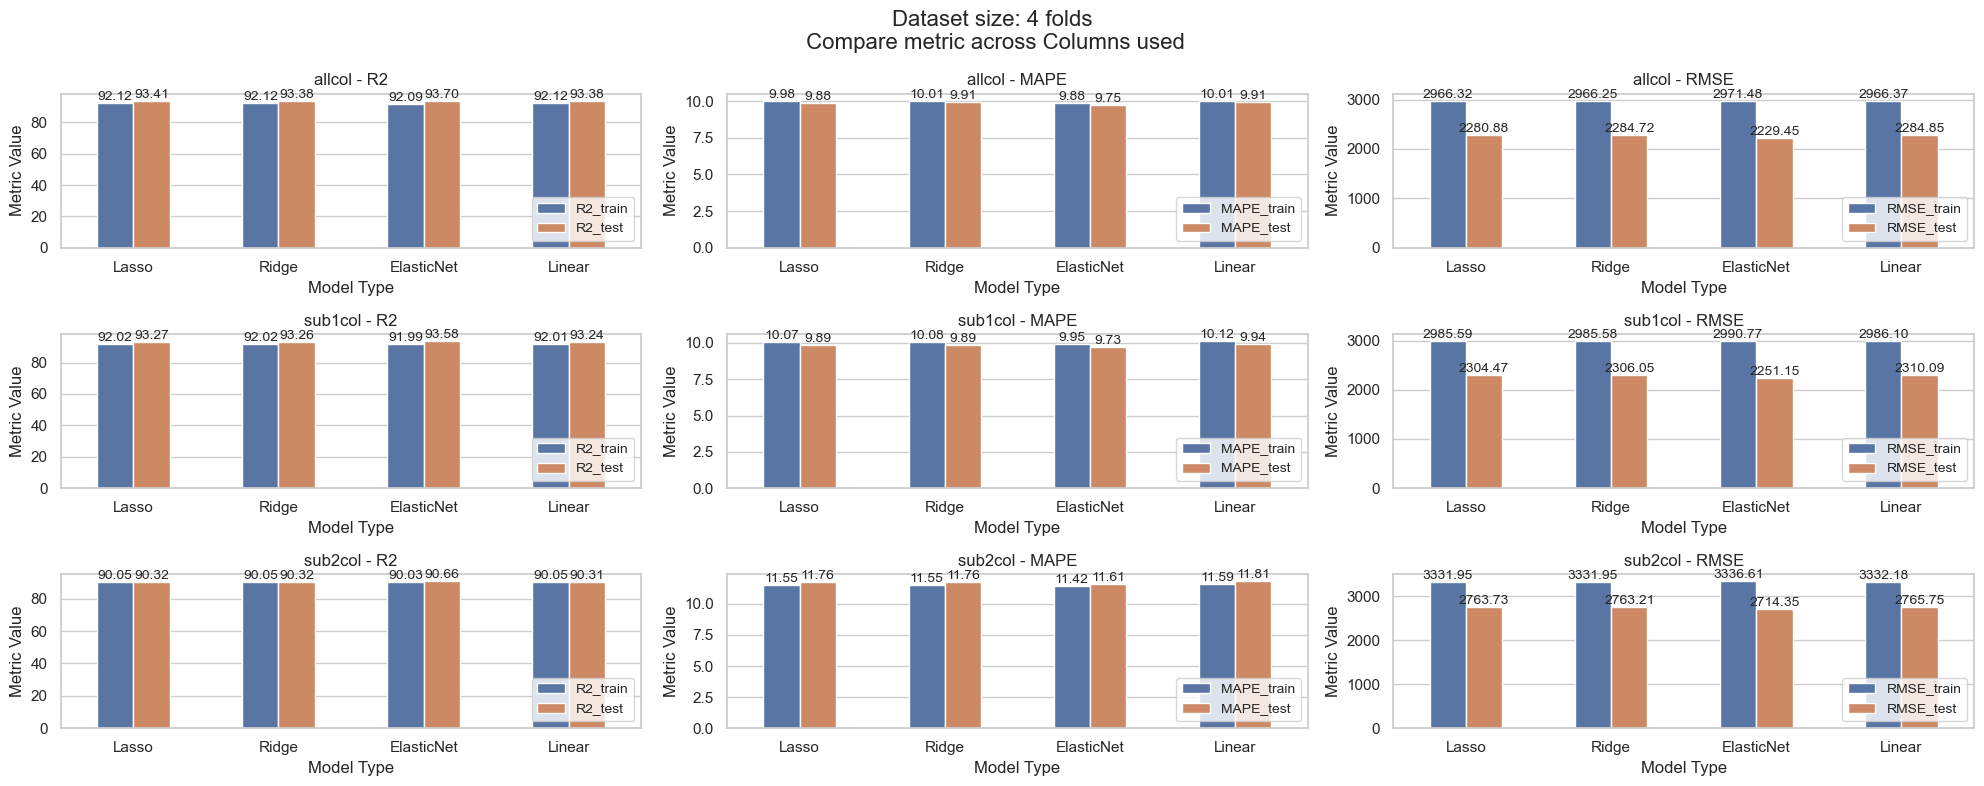

In [161]:
Main_condition = regressions_score_df['Data_size'] == '4fold'
Column_sets = regressions_score_df['Column_set'].unique()
metric_names = ['R2','MAPE','RMSE']

# Create a 3x3 subplot
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 8))

#Each row of subplot represents each number of data folds:
for i, nf_class in enumerate(Column_sets):
    #Each column of the subplot
    for j, metric in enumerate(metric_list):
        # Filter the DataFrame for the specific Number_of_fold_datasize class and Metric
        sec_cond = regressions_score_df['Column_set'] == nf_class
        filtered_df = regressions_score_df.loc[Main_condition & sec_cond, :]
        
        melted_df = pd.melt(filtered_df,
                            id_vars='Model_type',
                            value_vars=metric)
        # Set the subplot location
        ax = axes[i, j]
        
        # Creat subplot:
        sns.barplot(data=melted_df, x='Model_type', y='value', hue='variable',width=0.5, ax = ax)
        
        # Set the x-axis tick labels and the subplot title
        metric_name = metric_names[j]
        ax.set_title(f'{nf_class} - {metric_name}')

        # Set the subplot labels
        ax.set_xlabel('Model Type')
        ax.set_ylabel('Metric Value')

        # Add a legend
        # Add a legend and control its font size
        legend = ax.legend(fontsize=10, bbox_to_anchor=(1, 0), loc='lower right')
        
        # Add annotations to each bar
        for p in ax.patches:
            value = p.get_height()  # Get the height of each bar
            ax.annotate(f'{value:.2f}',  # Format the annotation to 2 decimal place
                        (p.get_x() + p.get_width() / 2, p.get_height()),  # Position the annotation at the center of the bar
                        ha='center', va='bottom',
                       fontsize=10)  # Set the alignment of the annotation
        

#Title
fig.suptitle('Dataset size: 4 folds\n Compare metric across Columns used', fontsize=16)

# Adjust the layout and spacing of subplots
plt.tight_layout()

# Show the plot
plt.show();

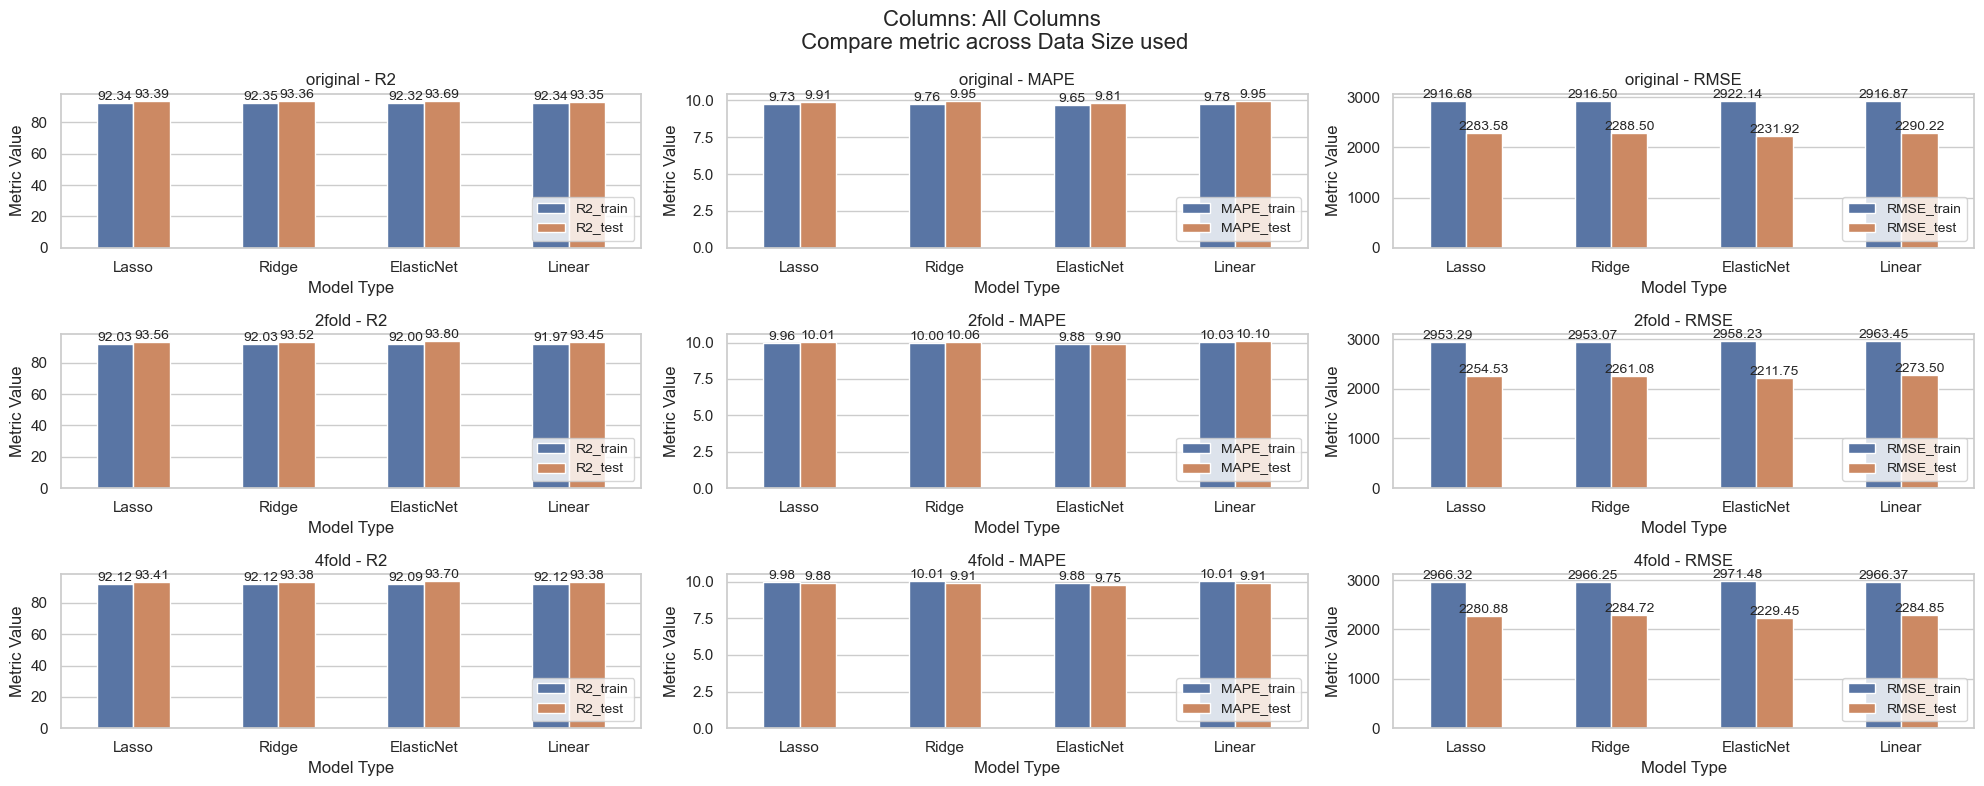

In [162]:
Main_condition = regressions_score_df['Column_set'] == 'allcol'
metric_names = ['R2','MAPE','RMSE']


# Create a 3x3 subplot
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 8))

#Each row of subplot represents each number of data folds:
for i, nf_class in enumerate(['original', '2fold', '4fold']):
    #Each column of the subplot
    for j, metric in enumerate(metric_list):
        # Filter the DataFrame for the specific Number_of_fold_datasize class and Metric
        sec_cond = regressions_score_df['Data_size'] == nf_class
        filtered_df = regressions_score_df.loc[Main_condition & sec_cond, :]
        
        melted_df = pd.melt(filtered_df,
                            id_vars='Model_type',
                            value_vars=metric)
        # Set the subplot location
        ax = axes[i, j]
        
        # Creat subplot:
        sns.barplot(data=melted_df, x='Model_type', y='value', hue='variable',width=0.5, ax = ax)
        
        # Set the x-axis tick labels and the subplot title
        metric_name = metric_names[j]
        ax.set_title(f'{nf_class} - {metric_name}')

        # Set the subplot labels
        ax.set_xlabel('Model Type')
        ax.set_ylabel('Metric Value')

        # Add a legend
        # Add a legend and control its font size
        legend = ax.legend(fontsize=10, bbox_to_anchor=(1, 0), loc='lower right')
        
        # Add annotations to each bar
        for p in ax.patches:
            value = p.get_height()  # Get the height of each bar
            ax.annotate(f'{value:.2f}',  # Format the annotation to 2 decimal place
                        (p.get_x() + p.get_width() / 2, p.get_height()),  # Position the annotation at the center of the bar
                        ha='center', va='bottom',
                       fontsize=10)  # Set the alignment of the annotation
        
#Title
fig.suptitle('Columns: All Columns\n Compare metric across Data Size used', fontsize=16)
        
# Adjust the layout and spacing of subplots
plt.tight_layout()

# Show the plot
plt.show();

In [145]:
metric_col = [col for col in regressions_score_df.columns if ('test' in col)]

for i in ['Column_set','Data_size','Model_type']:
    print(i)
    print(regressions_score_df.groupby(i)[metric_col].apply(get_min_max_df))
    print('\n')

Column_set
             Column Name  Minimum Value  Maximum Value
Column_set                                            
allcol     0     R2_test       93.35200       93.80000
           1   MAPE_test        9.75500       10.09700
           2   RMSE_test     2211.75222     2290.22037
sub1col    0     R2_test       93.18400       93.66300
           1   MAPE_test        9.73400       10.09600
           2   RMSE_test     2236.10935     2319.03683
sub2col    0     R2_test       90.26300       90.69500
           1   MAPE_test       11.61100       11.99500
           2   RMSE_test     2709.50804     2771.79742


Data_size
            Column Name  Minimum Value  Maximum Value
Data_size                                            
2fold     0     R2_test       90.37800       93.80000
          1   MAPE_test        9.89900       11.99500
          2   RMSE_test     2211.75222     2755.39328
4fold     0     R2_test       90.30500       93.70000
          1   MAPE_test        9.73400       11.

---
#### FEATURE IMPORTANCE

We will be looking at the coefficient value and its absolute value of the model `ElasticNet_4fold_allcol`.

Generally all the model performance are relatively similar.<br>
`ElasticNet_4fold_allcol` is chosen based on previous performance observation on R2 score:<br>
`All columns` appear to give better model performance.<br>
`4-fold` data size appear to give better model performance.<br>
`Elastic Net` appear to perform better than other statistical models.<br>

Furthermore, it make sense as:<br>
`All columns` allows more columns subjected to the regularization.<br>
`4-fold` all model to train better with better representation of the population<br>
`Elastic Net` allow use of l1 and l2 regularization<br>

In [49]:
def reg_coef_table(model,X):
    coefs = pd.DataFrame({'variable':X.columns,
                                'coef':model.coef_,
                                'abs_coef':np.abs(model.coef_)})

    coefs.sort_values('abs_coef', inplace=True, ascending=False)
    coefs.reset_index(drop=True, inplace = True)

    return coefs

In [50]:
coef_table = reg_coef_table(ElasticNet_4fold_allcol,X_train_data_ls[6])

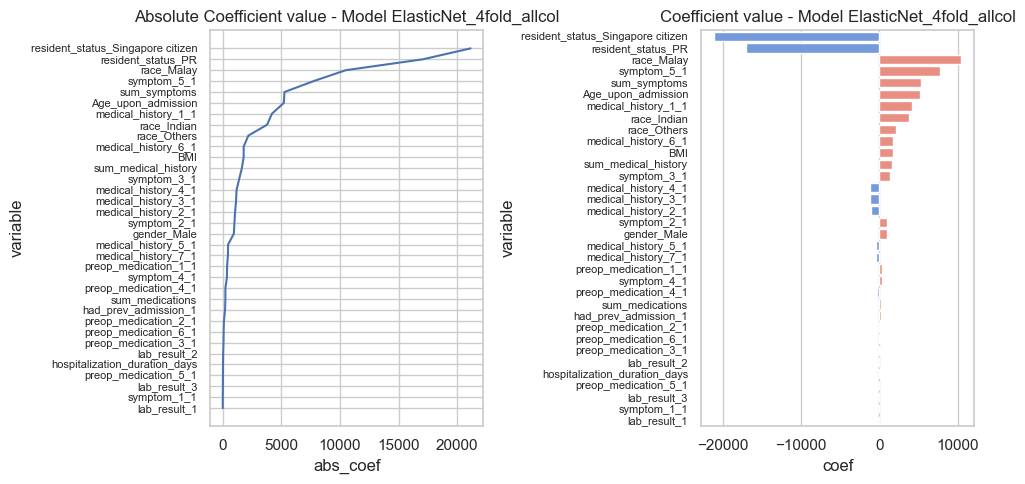

In [51]:
# Define the colors for negative and positive values
negative_color = 'cornflowerblue'
positive_color = 'salmon'

# Create a figure with two subplots
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Plot the line plot on the first subplot
sns.lineplot(data=coef_table, y='variable', x='abs_coef', ax=ax[0])
ax[0].set_yticks(range(len(coef_table['variable'])))
ax[0].set_yticklabels(coef_table['variable'], fontsize=8)
ax[0].set_title("Absolute Coefficient value - Model ElasticNet_4fold_allcol")

# Plot the bar plot on the second subplot
sns.barplot(data=coef_table, y='variable', x='coef', palette=[positive_color if x >= 0 else negative_color for x in coef_table['coef']], ax=ax[1])
ax[1].set_yticks(range(len(coef_table['variable'])))
ax[1].set_yticklabels(coef_table['variable'], fontsize=8)
ax[1].set_title("Coefficient value - Model ElasticNet_4fold_allcol")

# Adjust the layout and spacing
plt.tight_layout()

# Show the plot
plt.show();

In [56]:
index_value = int(coef_table[coef_table['variable'] == 'gender_Male'].index.tolist()[0])
index_value

17

In [58]:
# top selected features
coef_table.iloc[:index_value+2]

,variable,coef,abs_coef
0,resident_status_Singapore citizen,-21137.556782,21137.556782
1,resident_status_PR,-17074.856355,17074.856355
2,race_Malay,10504.958202,10504.958202
3,symptom_5_1,7766.408655,7766.408655
4,sum_symptoms,5275.406493,5275.406493
5,Age_upon_admission,5223.690500,5223.690500
6,medical_history_1_1,4201.757560,4201.757560
7,race_Indian,3797.650565,3797.650565
8,race_Others,2197.241629,2197.241629
9,medical_history_6_1,1803.137144,1803.137144


In [59]:
# Compile list of the selected features
top_selected_feat = coef_table.loc[:index_value,'variable'].tolist()
top_selected_feat

['resident_status_Singapore citizen',
 'resident_status_PR',
 'race_Malay',
 'symptom_5_1',
 'sum_symptoms',
 'Age_upon_admission',
 'medical_history_1_1',
 'race_Indian',
 'race_Others',
 'medical_history_6_1',
 'BMI',
 'sum_medical_history',
 'symptom_3_1',
 'medical_history_4_1',
 'medical_history_3_1',
 'medical_history_2_1',
 'symptom_2_1',
 'gender_Male']

---
##### Creating new X data with new sets of selected feature columns

In [60]:
list(X_test_dictionary.keys())[::3]
list(X_test_dictionary.keys())[::3]

['X_test_original_allcol', 'X_test_2fold_allcol', 'X_test_4fold_allcol']

['X_test_original_allcol', 'X_test_2fold_allcol', 'X_test_4fold_allcol']

In [61]:
# X_train_data_ls[::3] will call for data sets with the complete set of columns - X_train_original_allcol, X_train_2fold_allcol, X_train_4fold_allcol
X_train_allcol_set = X_train_data_ls[::3]

# X_test_data_ls[::3] will call for data sets with the complete set of columns - X_test_original_allcol, X_test_2fold_allcol, X_test_4fold_allcol
X_test_allcol_set = X_test_data_ls[::3]

In [62]:
print(f"Previous number of data in X_train_dictionary_2 = {len(list(X_train_dictionary_2.keys()))}")
print(f"Previous X_train_data_ls length = {len(X_train_data_ls)}")

for i in range(3):
    df = X_train_allcol_set[i]
    wanted_col = [col for col in df.columns if col in top_selected_feat]
    new_df = df.loc[:,top_selected_feat]
    new_name = f"X_train_{i*2}fold_sub3col"
    print(f'{new_name} created')
    
    X_train_data_ls.append(new_df)
    X_train_dictionary_2[new_name] = new_df
    
print(f"New number of data in X_train_dictionary_2 = {len(list(X_train_dictionary_2.keys()))}")
print(f"New X_train_data_ls length = {len(X_train_data_ls)}")

print(f"{list(X_train_dictionary_2.values()) == X_train_data_ls} that X dictionary identical to X list")

Previous number of data in X_train_dictionary_2 = 9
Previous X_train_data_ls length = 9
X_train_0fold_sub3col created
X_train_2fold_sub3col created
X_train_4fold_sub3col created
New number of data in X_train_dictionary_2 = 12
New X_train_data_ls length = 12
True that X dictionary identical to X list


In [63]:
print(f"Previous number of data in X_test_dictionary = {len(list(X_test_dictionary.keys()))}")
print(f"Previous X_test_data_ls length = {len(X_test_data_ls)}")

for i in range(3):
    df = X_test_allcol_set[i]
    wanted_col = [col for col in df.columns if col in top_selected_feat]
    new_df = df.loc[:,top_selected_feat]
    new_name = f"X_test_{i*2}fold_sub3col"
    print(f'{new_name} created')
    
    X_test_data_ls.append(new_df)
    X_test_dictionary[new_name] = new_df
    
print(f"New number of data in X_test_dictionary = {len(list(X_test_dictionary.keys()))}")
print(f"New X_test_data_ls length = {len(X_test_data_ls)}")

print(f"{list(X_test_dictionary.values()) == X_test_data_ls} that X dictionary identical to X list")

Previous number of data in X_test_dictionary = 9
Previous X_test_data_ls length = 9
X_test_0fold_sub3col created
X_test_2fold_sub3col created
X_test_4fold_sub3col created
New number of data in X_test_dictionary = 12
New X_test_data_ls length = 12
True that X dictionary identical to X list


In [64]:
for data in X_train_data_ls:
    print (data.shape)

(2550, 34)
(2550, 21)
(2550, 17)
(5100, 34)
(5100, 21)
(5100, 17)
(10200, 34)
(10200, 21)
(10200, 17)
(2550, 18)
(5100, 18)
(10200, 18)


In [65]:
for data in X_test_data_ls:
    print (data.shape)

(850, 34)
(850, 21)
(850, 17)
(850, 34)
(850, 21)
(850, 17)
(850, 34)
(850, 21)
(850, 17)
(850, 18)
(850, 18)
(850, 18)


**COMMENT**<br>

At this point:<br>
There is 1 set of y_test<br>
There is 3 sets of y train data (with different data size).<br>
There is 12 sets of X train data (with different data size AND column set).<br>
There is 12 sets of X test data (with different column set AND different transformers applied).<br>
There is 36 trained statistical models (using different models on different X data sets)

There is a `list` storing the X train data: `X_train_data_ls` with 12 X sets<br>
There is a `list` storing the X test data: `X_test_data_ls` with 12 X sets<br>
There is a `list` storing the y train data: `y_train_data_ls` with 3 y sets<br><br>
There is a `dictionary` storing the X train data: `X_train_dictionary_2` with 12 sets of X data<br>
There is a `dictionary` storing the X test data: `X_test_dictionary` with 12 sets of X data <br>
There is a `dictionary` storing the y train data: `y_train_dictionary` with 3 sets of y data<br><br>
There is a `dictionary` storing the X train data: `X_train_dictionary` with 3 initial sets of X data (*for reference if needed*) <br>


*Transformers & Estimators*<br>
There is a `dictionary` storing the X encoders: `encoders_dict`<br>
There is a `dictionary` storing the X scalers: `scalers_dict`<br>
There is a `dictionary` storing the fitted models: `models_dictionary` with 9 of each `Linear Regression` model types, total 36 models<br>

---
# Part 5: Machine Learning Models

## Datasets used in Part 5

Only data sets with `4fold` data size

In [66]:
_4fold_Xtrain = [col for col in list(X_train_dictionary_2.keys()) if '4fold' in col]
_4fold_Xtrain
indices = [list(X_train_dictionary_2.keys()).index(data) for data in _4fold_Xtrain]
indices

['X_train_4fold_allcol',
 'X_train_4fold_sub1col',
 'X_train_4fold_sub2col',
 'X_train_4fold_sub3col']

[6, 7, 8, 11]

In [67]:
_4fold_Xtrain_data = []
_4fold_Xtest_data = []

for i in indices:
    _4fold_Xtrain_data.append(X_train_data_ls[i])
    _4fold_Xtest_data.append(X_test_data_ls[i])    

In [68]:
#Each X train data should have 10200 rows, different number of colums
for i in _4fold_Xtrain_data:
    print(i.shape)
    
#Each X test data should have 10200 rows, different number of colums
for i in _4fold_Xtest_data:
    print(i.shape)

(10200, 34)
(10200, 21)
(10200, 17)
(10200, 18)
(850, 34)
(850, 21)
(850, 17)
(850, 18)


## 5.1 RandomForestRegressor

In [69]:
#lets look at the default parameters
rf = RandomForestRegressor(random_state=23)
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 23,
 'verbose': 0,
 'warm_start': False}

### 5.1.1 RandomizedSearchCV

In [70]:
#Let define the parameters to conduct RandomSearch
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 5)]
# Number of features to consider at every split
max_features = [None,'log2', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 90, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
random_grid

{'n_estimators': [200, 650, 1100, 1550, 2000],
 'max_features': [None, 'log2', 'sqrt'],
 'max_depth': [10, 30, 50, 70, 90, None],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4],
 'bootstrap': [True]}

In [71]:
%%time

models_dictionary_randomsrch = {}

# Create an empty dataframe
rf_scores_df = pd.DataFrame(columns=['Model',
                                  'y_train',
                                  'y_test',
                                  'X_train',
                                  'X_test',
                                  'R2_train',
                                  'R2_test',
                                  'MAPE_train',
                                  'MAPE_test',
                                  'RMSE_train',                                  
                                  'RMSE_test'])
score_df_col = list(rf_scores_df.columns)

#Parameters:
scorer = make_scorer(r2_score)
ytrain = y_train_4fold
ytest = y_test

progress = 1
for j in range(len(_4fold_Xtrain_data)):
    
    print(f"Progress: {progress}/4")
    progress = progress+1


    Xtrain = _4fold_Xtrain_data[j]
    Xtest = _4fold_Xtest_data[j]
    
    _4fold_Xtrain_name = [col for col in list(X_train_dictionary_2.keys()) if '4fold' in col][j]
    _4fold_Xtest_name = [col for col in list(X_test_dictionary.keys()) if '4fold' in col][j]

    model_name = f"RandomSearch_RandomForestRegressor_0{j}"

    rf = RandomForestRegressor(random_state=23,oob_score=True)
    model = RandomizedSearchCV(estimator = rf,
                               param_distributions = random_grid,
                               n_iter = 25,
                               scoring=scorer,
                               cv = 3,
                               random_state=23)
    
    model.fit(Xtrain, ytrain)

    globals()[model_name] = model
    models_dictionary_randomsrch[model_name] = model

    ytrain_pred = model.predict(Xtrain)
    ytest_pred = model.predict(Xtest)


    r2_score_train = model.score(Xtrain, ytrain).round(5)
    mape_score_train = mean_absolute_percentage_error(ytrain, ytrain_pred).round(5)
    rmse_score_train = mean_squared_error(ytrain, ytrain_pred, squared=False).round(5)


    r2_score_test = model.score(Xtest, ytest).round(5)
    mape_score_test = mean_absolute_percentage_error(ytest, ytest_pred).round(5)
    rmse_score_test = mean_squared_error(ytest, ytest_pred, squared=False).round(5)

    # Append scores to the dataframe
    new_append = [model_name,
           'y_train_4fold',
           'original y_test',
           _4fold_Xtrain_name,
           _4fold_Xtest_name,
           r2_score_train,
           r2_score_test,
           mape_score_train,
           mape_score_test,
           rmse_score_train,
           rmse_score_test]
    rf_scores_df = pd.concat([rf_scores_df,
                           pd.DataFrame({k:v for k,v in zip (score_df_col,new_append)},
                                        index=[0])],
                          ignore_index=True)
    
#convert R2 and MAPE score into percentage interpretability
_col = ['R2_train','R2_test','MAPE_train','MAPE_test']
rf_scores_df[_col] = rf_scores_df[_col]*100
rf_scores_df

Progress: 1/4
Progress: 2/4
Progress: 3/4
Progress: 4/4
CPU times: total: 50min 45s
Wall time: 51min 25s


,Model,y_train,y_test,X_train,X_test,R2_train,R2_test,MAPE_train,MAPE_test,RMSE_train,RMSE_test
0,RandomSearch_RandomForestRegressor_00,y_train_4fold,original y_test,X_train_4fold_allcol,X_test_4fold_allcol,99.947,88.398,0.357,9.057,244.36579,3025.62865
1,RandomSearch_RandomForestRegressor_01,y_train_4fold,original y_test,X_train_4fold_sub1col,X_test_4fold_sub1col,99.949,91.007,0.365,7.984,238.56176,2663.72187
2,RandomSearch_RandomForestRegressor_02,y_train_4fold,original y_test,X_train_4fold_sub2col,X_test_4fold_sub2col,99.910,91.011,0.435,9.206,317.51340,2663.17026
3,RandomSearch_RandomForestRegressor_03,y_train_4fold,original y_test,X_train_4fold_sub3col,X_test_4fold_sub3col,99.963,93.962,0.233,7.354,204.01515,2182.65451


In [72]:
rdm_search = list(models_dictionary_randomsrch.keys())
for i in rdm_search:
    print (models_dictionary_randomsrch[i].best_params_)

{'n_estimators': 1550, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 30, 'bootstrap': True}
{'n_estimators': 1550, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 30, 'bootstrap': True}
{'n_estimators': 2000, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': True}
{'n_estimators': 2000, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': True}


### 5.1.2 GridSearchCV

Let's narrow down the range for each hyperparameter.
- we see that the model is now overfitting
- choice of hyperparameter range will be more stringent to address it (*increase biase, reduce variace*)

In [73]:
%%time

# Create an empty dataframe
rf_scores_df = pd.DataFrame(columns=['Model',
                                  'y_train',
                                  'y_test',
                                  'X_train',
                                  'X_test',
                                  'R2_train',
                                  'R2_test',
                                  'MAPE_train',
                                  'MAPE_test',
                                  'RMSE_train',                                  
                                  'RMSE_test'])
score_df_col = list(rf_scores_df.columns)

#Parameters:
param_grid = {
    'n_estimators': [1500,2000],
    'min_samples_split': [5,8],
    'min_samples_leaf': [3,5],
    'max_features': ['sqrt','log2'],
    'max_depth': [10,20],
    'bootstrap': [True]}
scorer = make_scorer(r2_score)
ytrain = y_train_4fold
ytest = y_test

progress = 1
for j in range(len(_4fold_Xtrain_data)): 

    print(f"Progress: {progress}/4")
    progress = progress+1


    Xtrain = _4fold_Xtrain_data[j]
    Xtest = _4fold_Xtest_data[j]
    
    _4fold_Xtrain_name = [col for col in list(X_train_dictionary_2.keys()) if '4fold' in col][j]
    _4fold_Xtest_name = [col for col in list(X_test_dictionary.keys()) if '4fold' in col][j]

    model_name = f"RandomForestRegressor_0{j}"

    rf = RandomForestRegressor(random_state=23)
    model = GridSearchCV(estimator=rf, param_grid=param_grid,scoring=scorer, cv=3)
    model.fit(Xtrain, ytrain)
    globals()[model_name] = model

    ytrain_pred = model.predict(Xtrain)
    ytest_pred = model.predict(Xtest)


    r2_score_train = model.score(Xtrain, ytrain).round(5)
    mape_score_train = mean_absolute_percentage_error(ytrain, ytrain_pred).round(5)
    rmse_score_train = mean_squared_error(ytrain, ytrain_pred, squared=False).round(5)


    r2_score_test = model.score(Xtest, ytest).round(5)
    mape_score_test = mean_absolute_percentage_error(ytest, ytest_pred).round(5)
    rmse_score_test = mean_squared_error(ytest, ytest_pred, squared=False).round(5)

    # Append scores to the dataframe
    new_append = [model_name,
           'y_train_4fold',
           'original y_test',
           _4fold_Xtrain_name,
           _4fold_Xtest_name,
           r2_score_train,
           r2_score_test,
           mape_score_train,
           mape_score_test,
           rmse_score_train,
           rmse_score_test]
    rf_scores_df = pd.concat([rf_scores_df,
                           pd.DataFrame({k:v for k,v in zip (score_df_col,new_append)},
                                        index=[0])],
                          ignore_index=True)
    
#convert R2 and MAPE score into percentage interpretability
_col = ['R2_train','R2_test','MAPE_train','MAPE_test']
rf_scores_df[_col] = rf_scores_df[_col]*100
rf_scores_df

Progress: 1/4
Progress: 2/4
Progress: 3/4
Progress: 4/4
CPU times: total: 56min 56s
Wall time: 57min 35s


,Model,y_train,y_test,X_train,X_test,R2_train,R2_test,MAPE_train,MAPE_test,RMSE_train,RMSE_test
0,RandomForestRegressor_00,y_train_4fold,original y_test,X_train_4fold_allcol,X_test_4fold_allcol,98.936,88.396,2.310,11.612,1089.72116,3025.78274
1,RandomForestRegressor_01,y_train_4fold,original y_test,X_train_4fold_sub1col,X_test_4fold_sub1col,98.964,91.639,2.340,9.110,1075.26495,2568.48831
2,RandomForestRegressor_02,y_train_4fold,original y_test,X_train_4fold_sub2col,X_test_4fold_sub2col,98.623,90.883,3.252,9.240,1239.74201,2682.01766
3,RandomForestRegressor_03,y_train_4fold,original y_test,X_train_4fold_sub3col,X_test_4fold_sub3col,99.013,93.248,2.414,7.845,1049.77187,2308.06820


In [80]:
rdm_search = []
for i in range(4):
    name = f"RandomForestRegressor_0{i}"
    print (globals()[name].best_params_)

{'bootstrap': True, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 2000}
{'bootstrap': True, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 2000}
{'bootstrap': True, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 2000}
{'bootstrap': True, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 2000}


In [72]:
rdm_search = list(models_dictionary_randomsrch.keys())
for i in rdm_search:
    print (models_dictionary_randomsrch[i].best_params_)

{'n_estimators': 1550, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 30, 'bootstrap': True}
{'n_estimators': 1550, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 30, 'bootstrap': True}
{'n_estimators': 2000, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': True}
{'n_estimators': 2000, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': True}


### 5.1.3 Further hyperparametertuning

- The selected hyperparameters through `GridSearchCV` are generating overfitting model still despite reduced `max_depth`, and increased `min_samples_leaf` and `min_samples_split`.
- The difference between train and test R2 score are >7%.
- We will proceed to further fine tune our model by running through a combination of hyperpramaters, and visually inspect the `variance-bias` trade off for each X data set.

In [81]:
rf_scores_df = pd.DataFrame(columns=['Model',
                                  'y_train',
                                  'y_test',
                                  'X_train',
                                  'X_test',
                                  'R2_train',
                                  'R2_test',
                                  'MAPE_train',
                                  'MAPE_test',
                                  'RMSE_train',                                  
                                  'RMSE_test'])
score_df_col = list(rf_scores_df.columns)

scorer = make_scorer(r2_score)
ytrain = y_train_4fold
ytest = y_test

progress = 1
for j in range(len(_4fold_Xtrain_data)): 

    for max_dep in [20,40]:
        for min_leaf in range(5,8):
            for min_split in range(4,7):
                print(f"Progress: {progress}")

                #X
                Xtrain = _4fold_Xtrain_data[j]
                Xtest = _4fold_Xtest_data[j]

                _4fold_Xtrain_name = [col for col in list(X_train_dictionary_2.keys()) if '4fold' in col][j]
                _4fold_Xtest_name = [col for col in list(X_test_dictionary.keys()) if '4fold' in col][j]



                #Model
                model = RandomForestRegressor(random_state=23,
                                           n_estimators = 2000,
                                           min_samples_split = min_split,
                                           min_samples_leaf = min_leaf,
                                           max_features = 'sqrt',
                                           max_depth = max_dep,
                                           bootstrap = True)
                model.fit(Xtrain, ytrain)
                model_name = f"RandomForestRegressor_0{progress}"
                globals()[model_name] = model

                #Get prediction
                ytrain_pred = model.predict(Xtrain)
                ytest_pred = model.predict(Xtest)

                #Get metric scores
                r2_score_train = model.score(Xtrain, ytrain).round(5)
                mape_score_train = mean_absolute_percentage_error(ytrain, ytrain_pred).round(5)
                rmse_score_train = mean_squared_error(ytrain, ytrain_pred, squared=False).round(5)


                r2_score_test = model.score(Xtest, ytest).round(5)
                mape_score_test = mean_absolute_percentage_error(ytest, ytest_pred).round(5)
                rmse_score_test = mean_squared_error(ytest, ytest_pred, squared=False).round(5)

                # Append scores to the dataframe
                new_append = [model_name,
                       'y_train_4fold',
                       'original y_test',
                       _4fold_Xtrain_name,
                       _4fold_Xtest_name,
                       r2_score_train,
                       r2_score_test,
                       mape_score_train,
                       mape_score_test,
                       rmse_score_train,
                       rmse_score_test]
                rf_scores_df = pd.concat([rf_scores_df,
                                       pd.DataFrame({k:v for k,v in zip (score_df_col,new_append)},
                                                    index=[0])],
                                      ignore_index=True)
                progress = progress+1
                

#convert R2 and MAPE score into percentage interpretability
_col = ['R2_train','R2_test','MAPE_train','MAPE_test']
rf_scores_df[_col] = rf_scores_df[_col]*100
rf_scores_df                       

Progress: 1


RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=5,
                      min_samples_split=4, n_estimators=2000, random_state=23)

Progress: 2


RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=5,
                      min_samples_split=5, n_estimators=2000, random_state=23)

Progress: 3


RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=5,
                      min_samples_split=6, n_estimators=2000, random_state=23)

Progress: 4


RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=6,
                      min_samples_split=4, n_estimators=2000, random_state=23)

Progress: 5


RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=6,
                      min_samples_split=5, n_estimators=2000, random_state=23)

Progress: 6


RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=6,
                      min_samples_split=6, n_estimators=2000, random_state=23)

Progress: 7


RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=7,
                      min_samples_split=4, n_estimators=2000, random_state=23)

Progress: 8


RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=7,
                      min_samples_split=5, n_estimators=2000, random_state=23)

Progress: 9


RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=7,
                      min_samples_split=6, n_estimators=2000, random_state=23)

Progress: 10


RandomForestRegressor(max_depth=40, max_features='sqrt', min_samples_leaf=5,
                      min_samples_split=4, n_estimators=2000, random_state=23)

Progress: 11


RandomForestRegressor(max_depth=40, max_features='sqrt', min_samples_leaf=5,
                      min_samples_split=5, n_estimators=2000, random_state=23)

Progress: 12


RandomForestRegressor(max_depth=40, max_features='sqrt', min_samples_leaf=5,
                      min_samples_split=6, n_estimators=2000, random_state=23)

Progress: 13


RandomForestRegressor(max_depth=40, max_features='sqrt', min_samples_leaf=6,
                      min_samples_split=4, n_estimators=2000, random_state=23)

Progress: 14


RandomForestRegressor(max_depth=40, max_features='sqrt', min_samples_leaf=6,
                      min_samples_split=5, n_estimators=2000, random_state=23)

Progress: 15


RandomForestRegressor(max_depth=40, max_features='sqrt', min_samples_leaf=6,
                      min_samples_split=6, n_estimators=2000, random_state=23)

Progress: 16


RandomForestRegressor(max_depth=40, max_features='sqrt', min_samples_leaf=7,
                      min_samples_split=4, n_estimators=2000, random_state=23)

Progress: 17


RandomForestRegressor(max_depth=40, max_features='sqrt', min_samples_leaf=7,
                      min_samples_split=5, n_estimators=2000, random_state=23)

Progress: 18


RandomForestRegressor(max_depth=40, max_features='sqrt', min_samples_leaf=7,
                      min_samples_split=6, n_estimators=2000, random_state=23)

Progress: 19


RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=5,
                      min_samples_split=4, n_estimators=2000, random_state=23)

Progress: 20


RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=5,
                      min_samples_split=5, n_estimators=2000, random_state=23)

Progress: 21


RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=5,
                      min_samples_split=6, n_estimators=2000, random_state=23)

Progress: 22


RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=6,
                      min_samples_split=4, n_estimators=2000, random_state=23)

Progress: 23


RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=6,
                      min_samples_split=5, n_estimators=2000, random_state=23)

Progress: 24


RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=6,
                      min_samples_split=6, n_estimators=2000, random_state=23)

Progress: 25


RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=7,
                      min_samples_split=4, n_estimators=2000, random_state=23)

Progress: 26


RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=7,
                      min_samples_split=5, n_estimators=2000, random_state=23)

Progress: 27


RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=7,
                      min_samples_split=6, n_estimators=2000, random_state=23)

Progress: 28


RandomForestRegressor(max_depth=40, max_features='sqrt', min_samples_leaf=5,
                      min_samples_split=4, n_estimators=2000, random_state=23)

Progress: 29


RandomForestRegressor(max_depth=40, max_features='sqrt', min_samples_leaf=5,
                      min_samples_split=5, n_estimators=2000, random_state=23)

Progress: 30


RandomForestRegressor(max_depth=40, max_features='sqrt', min_samples_leaf=5,
                      min_samples_split=6, n_estimators=2000, random_state=23)

Progress: 31


RandomForestRegressor(max_depth=40, max_features='sqrt', min_samples_leaf=6,
                      min_samples_split=4, n_estimators=2000, random_state=23)

Progress: 32


RandomForestRegressor(max_depth=40, max_features='sqrt', min_samples_leaf=6,
                      min_samples_split=5, n_estimators=2000, random_state=23)

Progress: 33


RandomForestRegressor(max_depth=40, max_features='sqrt', min_samples_leaf=6,
                      min_samples_split=6, n_estimators=2000, random_state=23)

Progress: 34


RandomForestRegressor(max_depth=40, max_features='sqrt', min_samples_leaf=7,
                      min_samples_split=4, n_estimators=2000, random_state=23)

Progress: 35


RandomForestRegressor(max_depth=40, max_features='sqrt', min_samples_leaf=7,
                      min_samples_split=5, n_estimators=2000, random_state=23)

Progress: 36


RandomForestRegressor(max_depth=40, max_features='sqrt', min_samples_leaf=7,
                      min_samples_split=6, n_estimators=2000, random_state=23)

Progress: 37


RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=5,
                      min_samples_split=4, n_estimators=2000, random_state=23)

Progress: 38


RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=5,
                      min_samples_split=5, n_estimators=2000, random_state=23)

Progress: 39


RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=5,
                      min_samples_split=6, n_estimators=2000, random_state=23)

Progress: 40


RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=6,
                      min_samples_split=4, n_estimators=2000, random_state=23)

Progress: 41


RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=6,
                      min_samples_split=5, n_estimators=2000, random_state=23)

Progress: 42


RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=6,
                      min_samples_split=6, n_estimators=2000, random_state=23)

Progress: 43


RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=7,
                      min_samples_split=4, n_estimators=2000, random_state=23)

Progress: 44


RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=7,
                      min_samples_split=5, n_estimators=2000, random_state=23)

Progress: 45


RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=7,
                      min_samples_split=6, n_estimators=2000, random_state=23)

Progress: 46


RandomForestRegressor(max_depth=40, max_features='sqrt', min_samples_leaf=5,
                      min_samples_split=4, n_estimators=2000, random_state=23)

Progress: 47


RandomForestRegressor(max_depth=40, max_features='sqrt', min_samples_leaf=5,
                      min_samples_split=5, n_estimators=2000, random_state=23)

Progress: 48


RandomForestRegressor(max_depth=40, max_features='sqrt', min_samples_leaf=5,
                      min_samples_split=6, n_estimators=2000, random_state=23)

Progress: 49


RandomForestRegressor(max_depth=40, max_features='sqrt', min_samples_leaf=6,
                      min_samples_split=4, n_estimators=2000, random_state=23)

Progress: 50


RandomForestRegressor(max_depth=40, max_features='sqrt', min_samples_leaf=6,
                      min_samples_split=5, n_estimators=2000, random_state=23)

Progress: 51


RandomForestRegressor(max_depth=40, max_features='sqrt', min_samples_leaf=6,
                      min_samples_split=6, n_estimators=2000, random_state=23)

Progress: 52


RandomForestRegressor(max_depth=40, max_features='sqrt', min_samples_leaf=7,
                      min_samples_split=4, n_estimators=2000, random_state=23)

Progress: 53


RandomForestRegressor(max_depth=40, max_features='sqrt', min_samples_leaf=7,
                      min_samples_split=5, n_estimators=2000, random_state=23)

Progress: 54


RandomForestRegressor(max_depth=40, max_features='sqrt', min_samples_leaf=7,
                      min_samples_split=6, n_estimators=2000, random_state=23)

Progress: 55


RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=5,
                      min_samples_split=4, n_estimators=2000, random_state=23)

Progress: 56


RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=5,
                      min_samples_split=5, n_estimators=2000, random_state=23)

Progress: 57


RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=5,
                      min_samples_split=6, n_estimators=2000, random_state=23)

Progress: 58


RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=6,
                      min_samples_split=4, n_estimators=2000, random_state=23)

Progress: 59


RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=6,
                      min_samples_split=5, n_estimators=2000, random_state=23)

Progress: 60


RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=6,
                      min_samples_split=6, n_estimators=2000, random_state=23)

Progress: 61


RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=7,
                      min_samples_split=4, n_estimators=2000, random_state=23)

Progress: 62


RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=7,
                      min_samples_split=5, n_estimators=2000, random_state=23)

Progress: 63


RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=7,
                      min_samples_split=6, n_estimators=2000, random_state=23)

Progress: 64


RandomForestRegressor(max_depth=40, max_features='sqrt', min_samples_leaf=5,
                      min_samples_split=4, n_estimators=2000, random_state=23)

Progress: 65


RandomForestRegressor(max_depth=40, max_features='sqrt', min_samples_leaf=5,
                      min_samples_split=5, n_estimators=2000, random_state=23)

Progress: 66


RandomForestRegressor(max_depth=40, max_features='sqrt', min_samples_leaf=5,
                      min_samples_split=6, n_estimators=2000, random_state=23)

Progress: 67


RandomForestRegressor(max_depth=40, max_features='sqrt', min_samples_leaf=6,
                      min_samples_split=4, n_estimators=2000, random_state=23)

Progress: 68


RandomForestRegressor(max_depth=40, max_features='sqrt', min_samples_leaf=6,
                      min_samples_split=5, n_estimators=2000, random_state=23)

Progress: 69


RandomForestRegressor(max_depth=40, max_features='sqrt', min_samples_leaf=6,
                      min_samples_split=6, n_estimators=2000, random_state=23)

Progress: 70


RandomForestRegressor(max_depth=40, max_features='sqrt', min_samples_leaf=7,
                      min_samples_split=4, n_estimators=2000, random_state=23)

Progress: 71


RandomForestRegressor(max_depth=40, max_features='sqrt', min_samples_leaf=7,
                      min_samples_split=5, n_estimators=2000, random_state=23)

Progress: 72


RandomForestRegressor(max_depth=40, max_features='sqrt', min_samples_leaf=7,
                      min_samples_split=6, n_estimators=2000, random_state=23)

,Model,y_train,y_test,X_train,X_test,R2_train,R2_test,MAPE_train,MAPE_test,RMSE_train,RMSE_test
0,RandomForestRegressor_01,y_train_4fold,original y_test,X_train_4fold_allcol,X_test_4fold_allcol,96.978,87.576,4.380,12.034,1836.77105,3130.89750
1,RandomForestRegressor_02,y_train_4fold,original y_test,X_train_4fold_allcol,X_test_4fold_allcol,96.978,87.576,4.380,12.034,1836.77105,3130.89750
2,RandomForestRegressor_03,y_train_4fold,original y_test,X_train_4fold_allcol,X_test_4fold_allcol,96.978,87.576,4.380,12.034,1836.77105,3130.89750
3,RandomForestRegressor_04,y_train_4fold,original y_test,X_train_4fold_allcol,X_test_4fold_allcol,96.005,87.299,5.226,12.225,2111.70672,3165.62596
4,RandomForestRegressor_05,y_train_4fold,original y_test,X_train_4fold_allcol,X_test_4fold_allcol,96.005,87.299,5.226,12.225,2111.70672,3165.62596
...,...,...,...,...,...,...,...,...,...,...,...
67,RandomForestRegressor_068,y_train_4fold,original y_test,X_train_4fold_sub3col,X_test_4fold_sub3col,96.575,92.259,4.933,8.612,1955.44393,2471.37885
68,RandomForestRegressor_069,y_train_4fold,original y_test,X_train_4fold_sub3col,X_test_4fold_sub3col,96.575,92.259,4.933,8.612,1955.44393,2471.37885
69,RandomForestRegressor_070,y_train_4fold,original y_test,X_train_4fold_sub3col,X_test_4fold_sub3col,95.824,92.039,5.492,8.793,2159.06213,2506.25199
70,RandomForestRegressor_071,y_train_4fold,original y_test,X_train_4fold_sub3col,X_test_4fold_sub3col,95.824,92.039,5.492,8.793,2159.06213,2506.25199


In [82]:
#Dataset with all columns
rf_scores_df.iloc[:18,:].sort_values(by = 'R2_test',ascending = False)

,Model,y_train,y_test,X_train,X_test,R2_train,R2_test,MAPE_train,MAPE_test,RMSE_train,RMSE_test
0,RandomForestRegressor_01,y_train_4fold,original y_test,X_train_4fold_allcol,X_test_4fold_allcol,96.978,87.576,4.380,12.034,1836.77105,3130.89750
1,RandomForestRegressor_02,y_train_4fold,original y_test,X_train_4fold_allcol,X_test_4fold_allcol,96.978,87.576,4.380,12.034,1836.77105,3130.89750
2,RandomForestRegressor_03,y_train_4fold,original y_test,X_train_4fold_allcol,X_test_4fold_allcol,96.978,87.576,4.380,12.034,1836.77105,3130.89750
11,RandomForestRegressor_012,y_train_4fold,original y_test,X_train_4fold_allcol,X_test_4fold_allcol,96.989,87.574,4.360,11.997,1833.35342,3131.11742
10,RandomForestRegressor_011,y_train_4fold,original y_test,X_train_4fold_allcol,X_test_4fold_allcol,96.989,87.574,4.360,11.997,1833.35342,3131.11742
9,RandomForestRegressor_010,y_train_4fold,original y_test,X_train_4fold_allcol,X_test_4fold_allcol,96.989,87.574,4.360,11.997,1833.35342,3131.11742
12,RandomForestRegressor_013,y_train_4fold,original y_test,X_train_4fold_allcol,X_test_4fold_allcol,95.995,87.300,5.220,12.213,2114.59034,3165.50648
13,RandomForestRegressor_014,y_train_4fold,original y_test,X_train_4fold_allcol,X_test_4fold_allcol,95.995,87.300,5.220,12.213,2114.59034,3165.50648
14,RandomForestRegressor_015,y_train_4fold,original y_test,X_train_4fold_allcol,X_test_4fold_allcol,95.995,87.300,5.220,12.213,2114.59034,3165.50648
5,RandomForestRegressor_06,y_train_4fold,original y_test,X_train_4fold_allcol,X_test_4fold_allcol,96.005,87.299,5.226,12.225,2111.70672,3165.62596


**Selected model for `4fold_allcol` dataset**: `RandomForestRegressor_01`<br><br>
*All models overfit, but best performing model is RandomForestRegressor_01*

In [83]:
#Dataset with sub1 columns
rf_scores_df.iloc[18:18*2,:].sort_values(by = 'R2_test',ascending = False)

,Model,y_train,y_test,X_train,X_test,R2_train,R2_test,MAPE_train,MAPE_test,RMSE_train,RMSE_test
27,RandomForestRegressor_028,y_train_4fold,original y_test,X_train_4fold_sub1col,X_test_4fold_sub1col,97.255,91.072,4.240,9.521,1750.53593,2654.07307
29,RandomForestRegressor_030,y_train_4fold,original y_test,X_train_4fold_sub1col,X_test_4fold_sub1col,97.255,91.072,4.240,9.521,1750.53593,2654.07307
28,RandomForestRegressor_029,y_train_4fold,original y_test,X_train_4fold_sub1col,X_test_4fold_sub1col,97.255,91.072,4.240,9.521,1750.53593,2654.07307
19,RandomForestRegressor_020,y_train_4fold,original y_test,X_train_4fold_sub1col,X_test_4fold_sub1col,97.254,91.042,4.238,9.537,1750.91331,2658.58988
18,RandomForestRegressor_019,y_train_4fold,original y_test,X_train_4fold_sub1col,X_test_4fold_sub1col,97.254,91.042,4.238,9.537,1750.91331,2658.58988
20,RandomForestRegressor_021,y_train_4fold,original y_test,X_train_4fold_sub1col,X_test_4fold_sub1col,97.254,91.042,4.238,9.537,1750.91331,2658.58988
23,RandomForestRegressor_024,y_train_4fold,original y_test,X_train_4fold_sub1col,X_test_4fold_sub1col,96.411,90.703,4.962,9.759,2001.52348,2708.37497
22,RandomForestRegressor_023,y_train_4fold,original y_test,X_train_4fold_sub1col,X_test_4fold_sub1col,96.411,90.703,4.962,9.759,2001.52348,2708.37497
21,RandomForestRegressor_022,y_train_4fold,original y_test,X_train_4fold_sub1col,X_test_4fold_sub1col,96.411,90.703,4.962,9.759,2001.52348,2708.37497
30,RandomForestRegressor_031,y_train_4fold,original y_test,X_train_4fold_sub1col,X_test_4fold_sub1col,96.423,90.700,4.962,9.757,1998.34804,2708.78063


**Selected model for `4fold_sub1col` dataset**: `RandomForestRegressor_025`<br><br>
*Less overfit, with better performance is RandomForestRegressor_025*

In [84]:
#Dataset with sub2 columns
rf_scores_df.iloc[18*2:18*3,:].sort_values(by = 'R2_test',ascending = False)

,Model,y_train,y_test,X_train,X_test,R2_train,R2_test,MAPE_train,MAPE_test,RMSE_train,RMSE_test
36,RandomForestRegressor_037,y_train_4fold,original y_test,X_train_4fold_sub2col,X_test_4fold_sub2col,96.595,90.516,5.341,9.515,1949.72999,2735.46098
37,RandomForestRegressor_038,y_train_4fold,original y_test,X_train_4fold_sub2col,X_test_4fold_sub2col,96.595,90.516,5.341,9.515,1949.72999,2735.46098
38,RandomForestRegressor_039,y_train_4fold,original y_test,X_train_4fold_sub2col,X_test_4fold_sub2col,96.595,90.516,5.341,9.515,1949.72999,2735.46098
47,RandomForestRegressor_048,y_train_4fold,original y_test,X_train_4fold_sub2col,X_test_4fold_sub2col,96.595,90.493,5.344,9.522,1949.66195,2738.79479
46,RandomForestRegressor_047,y_train_4fold,original y_test,X_train_4fold_sub2col,X_test_4fold_sub2col,96.595,90.493,5.344,9.522,1949.66195,2738.79479
45,RandomForestRegressor_046,y_train_4fold,original y_test,X_train_4fold_sub2col,X_test_4fold_sub2col,96.595,90.493,5.344,9.522,1949.66195,2738.79479
48,RandomForestRegressor_049,y_train_4fold,original y_test,X_train_4fold_sub2col,X_test_4fold_sub2col,95.738,90.240,6.011,9.665,2181.30115,2774.96750
49,RandomForestRegressor_050,y_train_4fold,original y_test,X_train_4fold_sub2col,X_test_4fold_sub2col,95.738,90.240,6.011,9.665,2181.30115,2774.96750
50,RandomForestRegressor_051,y_train_4fold,original y_test,X_train_4fold_sub2col,X_test_4fold_sub2col,95.738,90.240,6.011,9.665,2181.30115,2774.96750
41,RandomForestRegressor_042,y_train_4fold,original y_test,X_train_4fold_sub2col,X_test_4fold_sub2col,95.741,90.236,6.010,9.666,2180.37575,2775.64214


**Selected model for `4fold_sub2col` dataset**: `RandomForestRegressor_043`<br><br>
*Less overfit, but best performing model is RandomForestRegressor_043*

In [85]:
#Dataset with sub3 columns
rf_scores_df.iloc[18*3:18*4,:].sort_values(by = 'R2_test',ascending = False)

,Model,y_train,y_test,X_train,X_test,R2_train,R2_test,MAPE_train,MAPE_test,RMSE_train,RMSE_test
54,RandomForestRegressor_055,y_train_4fold,original y_test,X_train_4fold_sub3col,X_test_4fold_sub3col,97.323,92.548,4.271,8.352,1728.85341,2424.79986
55,RandomForestRegressor_056,y_train_4fold,original y_test,X_train_4fold_sub3col,X_test_4fold_sub3col,97.323,92.548,4.271,8.352,1728.85341,2424.79986
56,RandomForestRegressor_057,y_train_4fold,original y_test,X_train_4fold_sub3col,X_test_4fold_sub3col,97.323,92.548,4.271,8.352,1728.85341,2424.79986
65,RandomForestRegressor_066,y_train_4fold,original y_test,X_train_4fold_sub3col,X_test_4fold_sub3col,97.339,92.545,4.265,8.363,1723.51501,2425.28883
64,RandomForestRegressor_065,y_train_4fold,original y_test,X_train_4fold_sub3col,X_test_4fold_sub3col,97.339,92.545,4.265,8.363,1723.51501,2425.28883
63,RandomForestRegressor_064,y_train_4fold,original y_test,X_train_4fold_sub3col,X_test_4fold_sub3col,97.339,92.545,4.265,8.363,1723.51501,2425.28883
59,RandomForestRegressor_060,y_train_4fold,original y_test,X_train_4fold_sub3col,X_test_4fold_sub3col,96.562,92.274,4.933,8.607,1958.96439,2468.98840
58,RandomForestRegressor_059,y_train_4fold,original y_test,X_train_4fold_sub3col,X_test_4fold_sub3col,96.562,92.274,4.933,8.607,1958.96439,2468.98840
57,RandomForestRegressor_058,y_train_4fold,original y_test,X_train_4fold_sub3col,X_test_4fold_sub3col,96.562,92.274,4.933,8.607,1958.96439,2468.98840
66,RandomForestRegressor_067,y_train_4fold,original y_test,X_train_4fold_sub3col,X_test_4fold_sub3col,96.575,92.259,4.933,8.612,1955.44393,2471.37885


**Selected model for `4fold_sub3col` dataset**: `RandomForestRegressor_066`<br><br>
*Less overfit, while having better performing model is RandomForestRegressor_066*

In [87]:
#Put selected model in the dictionary
suffix = ['_4fold_allcol','_4fold_sub1col','_4fold_sub2col','_4fold_sub3col']
model = [RandomForestRegressor_01,RandomForestRegressor_025,RandomForestRegressor_043,RandomForestRegressor_065]

for i in range(4):
    df_name = f'RandomForestRegressor{suffix[i]}'
    df = model[i]
    models_dictionary[df_name] = df
    globals()[df_name] = df

In [88]:
list(models_dictionary.keys())[-4:]

['RandomForestRegressor_4fold_allcol',
 'RandomForestRegressor_4fold_sub1col',
 'RandomForestRegressor_4fold_sub2col',
 'RandomForestRegressor_4fold_sub3col']

In [95]:
#Creating a subset of rf_scores_df, that contain only information about the selected random forest regressors
model = 'RandomForestRegressor_01,RandomForestRegressor_025,RandomForestRegressor_043,RandomForestRegressor_065'.split(',')
cond = rf_scores_df['Model'].isin(model)
selected_rfr_score_df = rf_scores_df.loc[cond,:].copy()
selected_rfr_score_df

,Model,y_train,y_test,X_train,X_test,R2_train,R2_test,MAPE_train,MAPE_test,RMSE_train,RMSE_test
0,RandomForestRegressor_01,y_train_4fold,original y_test,X_train_4fold_allcol,X_test_4fold_allcol,96.978,87.576,4.380,12.034,1836.77105,3130.89750
24,RandomForestRegressor_025,y_train_4fold,original y_test,X_train_4fold_sub1col,X_test_4fold_sub1col,95.571,90.485,5.577,9.959,2223.63392,2739.98994
42,RandomForestRegressor_043,y_train_4fold,original y_test,X_train_4fold_sub2col,X_test_4fold_sub2col,94.954,90.079,6.551,9.803,2373.40365,2797.87660
64,RandomForestRegressor_065,y_train_4fold,original y_test,X_train_4fold_sub3col,X_test_4fold_sub3col,97.339,92.545,4.265,8.363,1723.51501,2425.28883


In [98]:
#Replacing column 'Model' names
selected_rfr_score_df['Model'] = list(models_dictionary.keys())[-4:]
selected_rfr_score_df

,Model,y_train,y_test,X_train,X_test,R2_train,R2_test,MAPE_train,MAPE_test,RMSE_train,RMSE_test
0,RandomForestRegressor_4fold_allcol,y_train_4fold,original y_test,X_train_4fold_allcol,X_test_4fold_allcol,96.978,87.576,4.380,12.034,1836.77105,3130.89750
24,RandomForestRegressor_4fold_sub1col,y_train_4fold,original y_test,X_train_4fold_sub1col,X_test_4fold_sub1col,95.571,90.485,5.577,9.959,2223.63392,2739.98994
42,RandomForestRegressor_4fold_sub2col,y_train_4fold,original y_test,X_train_4fold_sub2col,X_test_4fold_sub2col,94.954,90.079,6.551,9.803,2373.40365,2797.87660
64,RandomForestRegressor_4fold_sub3col,y_train_4fold,original y_test,X_train_4fold_sub3col,X_test_4fold_sub3col,97.339,92.545,4.265,8.363,1723.51501,2425.28883


### Summary of 5.1
- The models perform generally poorer than statistical models which has R2 score 90-94%, while the RandomForestRegressors have R2 score 87-92.5%.
- The best model in this section is `RandomForestRegressor_4fold_sub3col` with test R2 of 92.5% and train-test R2 difference of 4.8%.

There are a few interesting observations in our exploration with `RandomForestRegressor`:
|Observation|Remarks|
|---|---|
|`Variance-bias tradeoff`|As the hyperparameter tunes and obtain `lower variance`, it reduces the gap between train and test metric (model less overfitting). Meanwhile, we observe that the model's performance on the test set reduces as the bias increases.|
|Model performance generally across different column set|<li>On given range of hyperparameters we experimented on, models using `sub3col` columns performed best on test set with `R2` score around 92% , VS other models thats 90% or less.<li>Recap `sub3col` contains transformed features with do not have close-to-zero coefficients in penalized regression model<li>We can infer that `RandomForestRegressor` performs better on unseen data when it is being trained on 'important' features on the hospital bill, while tends to have lesser performance when given other 'less' important features.|

**COMMENT**<br>

At this point:<br>
There is 1 set of y_test<br>
There is 3 sets of y train data (with different data size).<br>
There is 12 sets of X train data (with different data size AND column set).<br>
There is 12 sets of X test data (with different column set AND different transformers applied).<br>
There is 40 trained statistical models (using different models on different X data sets)

There is a `list` storing the X train data: `X_train_data_ls` with 12 X sets<br>
There is a `list` storing the X test data: `X_test_data_ls` with 12 X sets<br>
There is a `list` storing the y train data: `y_train_data_ls` with 3 y sets<br><br>
There is a `dictionary` storing the X train data: `X_train_dictionary_2` with 12 sets of X data<br>
There is a `dictionary` storing the X test data: `X_test_dictionary` with 12 sets of X data <br>
There is a `dictionary` storing the y train data: `y_train_dictionary` with 3 sets of y data<br><br>
There is a `dictionary` storing the X train data: `X_train_dictionary` with 3 initial sets of X data (*for reference if needed*) <br>


*Transformers & Estimators*<br>
There is a `dictionary` storing the X encoders: `encoders_dict`<br>
There is a `dictionary` storing the X scalers: `scalers_dict`<br>
There is a `dictionary` storing the fitted models: `models_dictionary` with total 40 models<br>

## 5.2 XGBRegressor
We will explore set of more stringent hyperparameter range to avoid overfitting

In [99]:
%%time
# Create an empty dataframe
xgb_scores_df = pd.DataFrame(columns=['Model',
                                  'y_train',
                                  'y_test',
                                  'X_train',
                                  'X_test',
                                  'R2_train',
                                  'R2_test',
                                  'MAPE_train',
                                  'MAPE_test',
                                  'RMSE_train',                                  
                                  'RMSE_test'])
score_df_col = list(xgb_scores_df.columns)

#Parameters:
param_grid = {
    'colsample_bytree': [0.5,0.75],
    'n_estimators': [50,100,150],
    'subsample': [0.75],
    'max_depth': [3,5],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 5, 10],
    'lambda': [0.1, 1, 10],
    'alpha': [0.1, 1, 10]}
#scorer
scorer = make_scorer(r2_score)
#y
ytrain = y_train_4fold
ytest = y_test

#suffix:
suffix = ['_4fold_allcol','_4fold_sub1col','_4fold_sub2col','_4fold_sub3col']


progress = 1
for j in range(len(_4fold_Xtrain_data)):
    print(f"Progress: {progress}/4")
    progress = progress+1


    Xtrain = _4fold_Xtrain_data[j]
    Xtest = _4fold_Xtest_data[j]
    
    _4fold_Xtrain_name = [col for col in list(X_train_dictionary_2.keys()) if '4fold' in col][j]
    _4fold_Xtest_name = [col for col in list(X_test_dictionary.keys()) if '4fold' in col][j]

    model_name = f"XGBRegressor{suffix[j]}"

    xg_grid_reg = xgb.XGBRegressor(objective= "reg:squarederror")
    model = GridSearchCV(estimator=xg_grid_reg,
                    param_grid=param_grid,
                    scoring=scorer,
                    cv=5)
    
    model.fit(Xtrain, ytrain)

    globals()[model_name] = model
    models_dictionary[model_name] = model

    ytrain_pred = model.predict(Xtrain)
    ytest_pred = model.predict(Xtest)


    r2_score_train = model.score(Xtrain, ytrain).round(5)
    mape_score_train = mean_absolute_percentage_error(ytrain, ytrain_pred).round(5)
    rmse_score_train = mean_squared_error(ytrain, ytrain_pred, squared=False).round(5)


    r2_score_test = model.score(Xtest, ytest).round(5)
    mape_score_test = mean_absolute_percentage_error(ytest, ytest_pred).round(5)
    rmse_score_test = mean_squared_error(ytest, ytest_pred, squared=False).round(5)

    # Append scores to the dataframe
    new_append = [model_name,
           'y_train_4fold',
           'original y_test',
           _4fold_Xtrain_name,
           _4fold_Xtest_name,
           r2_score_train,
           r2_score_test,
           mape_score_train,
           mape_score_test,
           rmse_score_train,
           rmse_score_test]
    xgb_scores_df = pd.concat([xgb_scores_df,
                           pd.DataFrame({k:v for k,v in zip (score_df_col,new_append)},
                                        index=[0])],
                          ignore_index=True)
    
#convert R2 and MAPE score into percentage interpretability
_col = ['R2_train','R2_test','MAPE_train','MAPE_test']
xgb_scores_df[_col] = xgb_scores_df[_col]*100

Progress: 1/4
Progress: 2/4
Progress: 3/4
Progress: 4/4
CPU times: total: 1h 27min 36s
Wall time: 1h 28min 24s


In [100]:
xgb_scores_df

,Model,y_train,y_test,X_train,X_test,R2_train,R2_test,MAPE_train,MAPE_test,RMSE_train,RMSE_test
0,XGBRegressor_4fold_allcol,y_train_4fold,original y_test,X_train_4fold_allcol,X_test_4fold_allcol,99.989,94.494,0.275,6.957,111.36674,2084.22128
1,XGBRegressor_4fold_sub1col,y_train_4fold,original y_test,X_train_4fold_sub1col,X_test_4fold_sub1col,99.979,96.781,0.470,5.385,154.23175,1593.68932
2,XGBRegressor_4fold_sub2col,y_train_4fold,original y_test,X_train_4fold_sub2col,X_test_4fold_sub2col,99.891,91.332,1.112,8.941,348.58930,2615.14275
3,XGBRegressor_4fold_sub3col,y_train_4fold,original y_test,X_train_4fold_sub3col,X_test_4fold_sub3col,99.991,95.331,0.370,6.174,102.07997,1919.26713


In [101]:
for i in list(models_dictionary.keys())[-4:]:
    print(models_dictionary[i].best_params_)

{'alpha': 0.1, 'colsample_bytree': 0.75, 'lambda': 10, 'max_depth': 7, 'min_child_weight': 5, 'n_estimators': 150, 'subsample': 0.75}
{'alpha': 10, 'colsample_bytree': 0.75, 'lambda': 10, 'max_depth': 7, 'min_child_weight': 5, 'n_estimators': 150, 'subsample': 0.75}
{'alpha': 10, 'colsample_bytree': 0.75, 'lambda': 0.1, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 150, 'subsample': 0.75}
{'alpha': 0.1, 'colsample_bytree': 0.75, 'lambda': 0.1, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 150, 'subsample': 0.75}


**COMMENTS**
- The models are generally overfitting (i.e. the discrepancy between train and test R2 score is about 5% or more)
- We will further tune the model

In [102]:
%%time
# Create an empty dataframe
xgb_scores_df = pd.DataFrame(columns=['Model',
                                  'y_train',
                                  'y_test',
                                  'X_train',
                                  'X_test',
                                  'R2_train',
                                  'R2_test',
                                  'MAPE_train',
                                  'MAPE_test',
                                  'RMSE_train',                                  
                                  'RMSE_test'])
score_df_col = list(xgb_scores_df.columns)

#Parameters:
param_grid = {
    'colsample_bytree': [0.75],
    'n_estimators': [2000],
    'subsample': [0.75],
    'max_depth': [3,5],
    'lambda': [0.1, 1, 10],
    'alpha': [0.1, 1, 10]}
#scorer
scorer = make_scorer(r2_score)
#y
ytrain = y_train_4fold
ytest = y_test

#suffix:
suffix = ['_4fold_allcol','_4fold_sub1col','_4fold_sub2col','_4fold_sub3col']


progress = 1
for j in range(len(_4fold_Xtrain_data)):
    print(f"Progress: {progress}/4")
    progress = progress+1


    Xtrain = _4fold_Xtrain_data[j]
    Xtest = _4fold_Xtest_data[j]
    
    _4fold_Xtrain_name = [col for col in list(X_train_dictionary_2.keys()) if '4fold' in col][j]
    _4fold_Xtest_name = [col for col in list(X_test_dictionary.keys()) if '4fold' in col][j]

    model_name = f"XGBRegressor{suffix[j]}"

    xg_grid_reg = xgb.XGBRegressor(objective= "reg:squarederror")
    model = GridSearchCV(estimator=xg_grid_reg,
                    param_grid=param_grid,
                    scoring=scorer,
                    cv=3)
    
    model.fit(Xtrain, ytrain)

    globals()[model_name] = model
    models_dictionary[model_name] = model

    ytrain_pred = model.predict(Xtrain)
    ytest_pred = model.predict(Xtest)


    r2_score_train = model.score(Xtrain, ytrain).round(5)
    mape_score_train = mean_absolute_percentage_error(ytrain, ytrain_pred).round(5)
    rmse_score_train = mean_squared_error(ytrain, ytrain_pred, squared=False).round(5)


    r2_score_test = model.score(Xtest, ytest).round(5)
    mape_score_test = mean_absolute_percentage_error(ytest, ytest_pred).round(5)
    rmse_score_test = mean_squared_error(ytest, ytest_pred, squared=False).round(5)

    # Append scores to the dataframe
    new_append = [model_name,
           'y_train_4fold',
           'original y_test',
           _4fold_Xtrain_name,
           _4fold_Xtest_name,
           r2_score_train,
           r2_score_test,
           mape_score_train,
           mape_score_test,
           rmse_score_train,
           rmse_score_test]
    xgb_scores_df = pd.concat([xgb_scores_df,
                           pd.DataFrame({k:v for k,v in zip (score_df_col,new_append)},
                                        index=[0])],
                          ignore_index=True)
    
#convert R2 and MAPE score into percentage interpretability
_col = ['R2_train','R2_test','MAPE_train','MAPE_test']
xgb_scores_df[_col] = xgb_scores_df[_col]*100

Progress: 1/4
Progress: 2/4
Progress: 3/4
Progress: 4/4
CPU times: total: 26min 40s
Wall time: 26min 47s


In [103]:
xgb_scores_df

,Model,y_train,y_test,X_train,X_test,R2_train,R2_test,MAPE_train,MAPE_test,RMSE_train,RMSE_test
0,XGBRegressor_4fold_allcol,y_train_4fold,original y_test,X_train_4fold_allcol,X_test_4fold_allcol,99.987,97.732,0.375,4.932,120.78346,1337.71927
1,XGBRegressor_4fold_sub1col,y_train_4fold,original y_test,X_train_4fold_sub1col,X_test_4fold_sub1col,99.985,97.804,0.454,4.616,128.17734,1316.16081
2,XGBRegressor_4fold_sub2col,y_train_4fold,original y_test,X_train_4fold_sub2col,X_test_4fold_sub2col,99.935,92.694,0.660,8.758,269.56463,2400.98342
3,XGBRegressor_4fold_sub3col,y_train_4fold,original y_test,X_train_4fold_sub3col,X_test_4fold_sub3col,99.979,97.798,0.554,4.764,151.68395,1318.01607


In [104]:
for i in list(models_dictionary.keys())[-4:]:
    print(i)
    print(models_dictionary[i].best_params_)
    print('\n')

XGBRegressor_4fold_allcol
{'alpha': 1, 'colsample_bytree': 0.75, 'lambda': 10, 'max_depth': 3, 'n_estimators': 2000, 'subsample': 0.75}


XGBRegressor_4fold_sub1col
{'alpha': 0.1, 'colsample_bytree': 0.75, 'lambda': 1, 'max_depth': 3, 'n_estimators': 2000, 'subsample': 0.75}


XGBRegressor_4fold_sub2col
{'alpha': 10, 'colsample_bytree': 0.75, 'lambda': 0.1, 'max_depth': 5, 'n_estimators': 2000, 'subsample': 0.75}


XGBRegressor_4fold_sub3col
{'alpha': 0.1, 'colsample_bytree': 0.75, 'lambda': 1, 'max_depth': 3, 'n_estimators': 2000, 'subsample': 0.75}




**COMMENTS**
- We have succesfully narrow the gap between train and test performance (i.e. train and test R2 score difference is generally about 3%, except for XGBRegressor_4fold_sub2col).
- The other models has great performance without overfitting, with similar performance on test set (R2 score ~ 97.5%).

**COMMENT**<br>

At this point:<br>
There is 1 set of y_test<br>
There is 3 sets of y train data (with different data size).<br>
There is 12 sets of X train data (with different data size AND column set).<br>
There is 12 sets of X test data (with different column set AND different transformers applied).<br>
There is 44 trained statistical models (using different models on different X data sets)

There is a `list` storing the X train data: `X_train_data_ls` with 12 X sets<br>
There is a `list` storing the X test data: `X_test_data_ls` with 12 X sets<br>
There is a `list` storing the y train data: `y_train_data_ls` with 3 y sets<br><br>
There is a `dictionary` storing the X train data: `X_train_dictionary_2` with 12 sets of X data<br>
There is a `dictionary` storing the X test data: `X_test_dictionary` with 12 sets of X data <br>
There is a `dictionary` storing the y train data: `y_train_dictionary` with 3 sets of y data<br><br>
There is a `dictionary` storing the X train data: `X_train_dictionary` with 3 initial sets of X data (*for reference if needed*) <br>


*Transformers & Estimators*<br>
There is a `dictionary` storing the X encoders: `encoders_dict`<br>
There is a `dictionary` storing the X scalers: `scalers_dict`<br>
There is a `dictionary` storing the fitted models: `models_dictionary` with total 44 models<br>

## 5.3 Assess scores

In [165]:
mlmodels_scores_df = pd.concat([selected_rfr_score_df,xgb_scores_df], axis=0)
mlmodels_scores_df.drop(columns = [col for col in mlmodels_scores_df.columns if ('X' in col) or ('y' in col)], inplace=True)
mlmodels_scores_df

,Model,R2_train,R2_test,MAPE_train,MAPE_test,RMSE_train,RMSE_test
0,RandomForestRegressor_4fold_allcol,96.978,87.576,4.380,12.034,1836.77105,3130.89750
24,RandomForestRegressor_4fold_sub1col,95.571,90.485,5.577,9.959,2223.63392,2739.98994
42,RandomForestRegressor_4fold_sub2col,94.954,90.079,6.551,9.803,2373.40365,2797.87660
64,RandomForestRegressor_4fold_sub3col,97.339,92.545,4.265,8.363,1723.51501,2425.28883
0,XGBRegressor_4fold_allcol,99.987,97.732,0.375,4.932,120.78346,1337.71927
1,XGBRegressor_4fold_sub1col,99.985,97.804,0.454,4.616,128.17734,1316.16081
2,XGBRegressor_4fold_sub2col,99.935,92.694,0.660,8.758,269.56463,2400.98342
3,XGBRegressor_4fold_sub3col,99.979,97.798,0.554,4.764,151.68395,1318.01607


In [166]:
#Sort model performance based on R2 score
mlmodels_scores_df.sort_values(by = 'R2_test', ascending = False)

,Model,R2_train,R2_test,MAPE_train,MAPE_test,RMSE_train,RMSE_test
1,XGBRegressor_4fold_sub1col,99.985,97.804,0.454,4.616,128.17734,1316.16081
3,XGBRegressor_4fold_sub3col,99.979,97.798,0.554,4.764,151.68395,1318.01607
0,XGBRegressor_4fold_allcol,99.987,97.732,0.375,4.932,120.78346,1337.71927
2,XGBRegressor_4fold_sub2col,99.935,92.694,0.660,8.758,269.56463,2400.98342
64,RandomForestRegressor_4fold_sub3col,97.339,92.545,4.265,8.363,1723.51501,2425.28883
24,RandomForestRegressor_4fold_sub1col,95.571,90.485,5.577,9.959,2223.63392,2739.98994
42,RandomForestRegressor_4fold_sub2col,94.954,90.079,6.551,9.803,2373.40365,2797.87660
0,RandomForestRegressor_4fold_allcol,96.978,87.576,4.380,12.034,1836.77105,3130.89750


In [167]:
# Sort models based on Mape score
mlmodels_scores_df.sort_values(by = 'MAPE_test')

,Model,R2_train,R2_test,MAPE_train,MAPE_test,RMSE_train,RMSE_test
1,XGBRegressor_4fold_sub1col,99.985,97.804,0.454,4.616,128.17734,1316.16081
3,XGBRegressor_4fold_sub3col,99.979,97.798,0.554,4.764,151.68395,1318.01607
0,XGBRegressor_4fold_allcol,99.987,97.732,0.375,4.932,120.78346,1337.71927
64,RandomForestRegressor_4fold_sub3col,97.339,92.545,4.265,8.363,1723.51501,2425.28883
2,XGBRegressor_4fold_sub2col,99.935,92.694,0.660,8.758,269.56463,2400.98342
42,RandomForestRegressor_4fold_sub2col,94.954,90.079,6.551,9.803,2373.40365,2797.87660
24,RandomForestRegressor_4fold_sub1col,95.571,90.485,5.577,9.959,2223.63392,2739.98994
0,RandomForestRegressor_4fold_allcol,96.978,87.576,4.380,12.034,1836.77105,3130.89750


### Summary of Machine Learning Models Performance
- XGBRegressor generally performs better than RandomForestRegressor
- RandomForestRegressor performs better when trained on specific important features, while XGBRegressor showed better performance when more columns (it perform least  well on `sub2col` which had least columns)
- We can infer XGBRegressor is better selecting important features and this is make sense:
    - XGBoost offers the ability to adjust regularization parameters, granting users precise control to fine-tune the complexity of the model. It provides choices like L1 and L2 regularization, which aid in mitigating overfitting and enhancing generalization. 
    - In contrast, Random Forest Regressor relies on the natural randomness inherent in its ensemble construction to regulate the model, lacking direct influence over regularization parameters.

# Part 6: Discussion & Conclusion

**Aim of the project**:
1. Find factors that drive cost of hospitalisation care
1. Find ways to estimate hospitalisation cost (through modelling)

**What have we done:**
- Did data analysis to identify features that influence hospitalisation bill.
- Performed statistical models and machine learning models to find best bill estimator with R2 score >90% and MAPE <10%

**Now**
- Lets look at our model performanc overall and Identify key importance features that influence hospitalisation bill.

## Model Performances

|Modelling Approach|Description|
|---|---|
|Statistical Model|<li>4 Model types: Linear Regression, LassoCV, RidgeCV, ElasticNetCV <li>9 X data sets used<li>Total 36 trained statistical models<br><br><li>Not overfitting (Train-test R2 score difference less than 5%)<li>Well performing with >90% R2 test score.<li>Very similar performance with R2 test score ranging narrowly 90-94%|
|Machine Learning Model|<li>2 Model types: RandomForestRegressor, XGBoostRegressor<li>4 Xdata sets used (Datasize: 4fold, Column set: allcol, sub1col, sub2col, sub3col)<li>Total 8 trained machine learning models<br><br><li>`RandomForestRegressor` appear to perform similar or poorer than the statistical modesl with R2 score ranging from 87.6% to 92.5%<li>`XGBRegressor` appear to perform best with R2 score around 98% without overfitting, except when using `sub2col` which has the smallest set of columns.|
    
Selected Best Model: `XGBRegressor_4fold_sub3col`<br>
- Rationale: The models peformance across other 2 XGBRegressors are similar. We then look at the columns used. We selected the model that used the selected important features identified from statistical modelling as these are the key features identified through modelling (compared to the other approach which is through pre-modelling simplier analysis).
- `R2 score` 97.8%
- `MAPE score` 4.76%
- `R2 score` 1318
    
What this translates to is:<br>
Given a patient information during hospitalisation (found in `sub3col`), it is able to estimate the hospital bill with about ~5% and \\$1.3K off the true bill value. 



## Feature Importance
[Reference](https://stackabuse.com/bytes/get-feature-importance-from-xgbregressor-with-xgboost/)

In [116]:
#Best performing model RandomForestRegressor_4fold_sub3col:
k = RandomForestRegressor_4fold_sub3col.feature_names_in_
v = RandomForestRegressor_4fold_sub3col.feature_importances_.round(5)

randforestreg_feat_impt_df = pd.DataFrame({'Feature': k, 'Importance': v},
                               columns=['Feature', 'Importance']).sort_values(by = 'Importance', ascending= False)
randforestreg_feat_impt_df.reset_index(drop=True, inplace=True)

In [168]:
#Higher importance score indicates that the feature has more importance or predictive power in the model. 
_dict = XGBRegressor_4fold_sub3col.best_estimator_.get_booster().get_score(importance_type='gain')
xgbreg_feat_impt_df = pd.DataFrame({'Feature': list(_dict.keys()), 'Importance': list(_dict.values())})
xgbreg_feat_impt_df = xgbreg_feat_impt_df.sort_values(by ='Importance', ascending = False)
xgbreg_feat_impt_df.reset_index(drop = True, inplace=True)

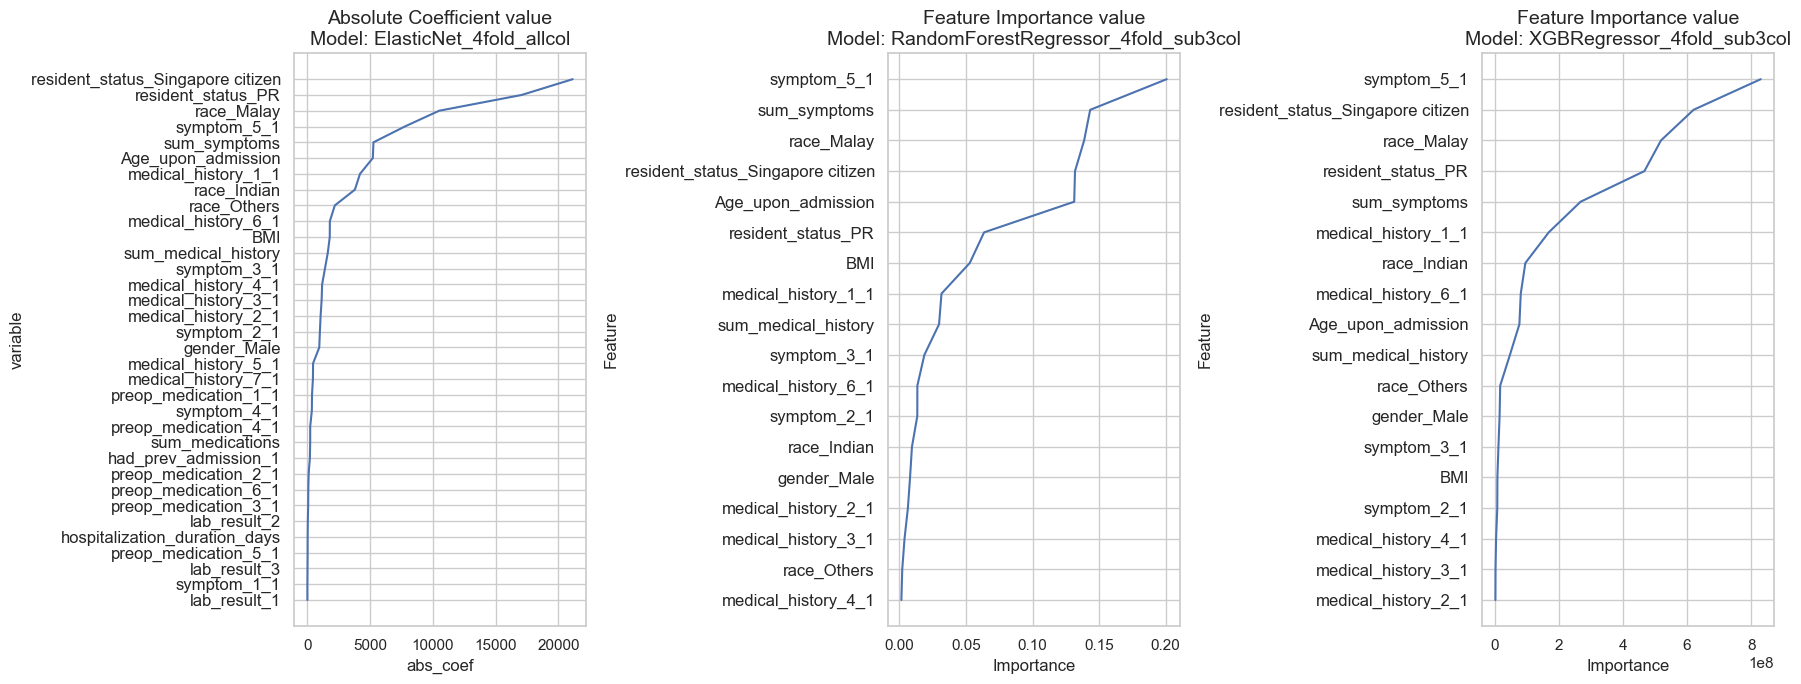

In [171]:
# Create a figure with three subplots showing feature importance across the three models
fig, ax = plt.subplots(1, 3, figsize=(18, 7))

# Plot the line plot on the first subplot
sns.lineplot(data=coef_table, y='variable', x='abs_coef', ax=ax[0])
ax[0].set_yticks(range(len(coef_table['variable'])))
ax[0].set_yticklabels(coef_table['variable'], fontsize=12)
ax[0].set_title("Absolute Coefficient value\nModel: ElasticNet_4fold_allcol",fontsize = 14)

# Plot the bar plot on the second subplot
sns.lineplot(data=randforestreg_feat_impt_df, x='Importance', y='Feature', ax=ax[1])
ax[1].set_yticks(range(len(randforestreg_feat_impt_df)))
ax[1].set_yticklabels(randforestreg_feat_impt_df['Feature'], fontsize=12)
ax[1].set_title("Feature Importance value\nModel: RandomForestRegressor_4fold_sub3col",fontsize = 14)

# Plot the bar plot on the second subplot
sns.lineplot(data=xgbreg_feat_impt_df, x='Importance', y='Feature', ax=ax[2])
ax[2].set_yticks(range(len(xgbreg_feat_impt_df)))
ax[2].set_yticklabels(xgbreg_feat_impt_df['Feature'], fontsize=12)
ax[2].set_title("Feature Importance value\nModel: XGBRegressor_4fold_sub3col",fontsize = 14)

# Adjust the layout and spacing
plt.tight_layout()

# Show the plot
plt.show();

In [172]:
elasticnet_top10_feat = set(coef_table.loc[:10,'variable'])
rdmforestreg_top10_feat = set(randforestreg_feat_impt_df.loc[:10,'Feature'])
xgbreg_top10_feat = set(xgbreg_feat_impt_df.loc[:10,'Feature'])
common_top10set = elasticnet_top10_feat&rdmforestreg_top10_feat&xgbreg_top10_feat
print('Common Top 10 Features')
list(common_top10set)

Common Top 10 Features


['medical_history_6_1',
 'resident_status_PR',
 'medical_history_1_1',
 'race_Malay',
 'Age_upon_admission',
 'resident_status_Singapore citizen',
 'sum_symptoms',
 'symptom_5_1']

In [173]:
elasticnet_top5_feat = set(coef_table.loc[:5,'variable'])
rdmforestreg_top5_feat = set(randforestreg_feat_impt_df.loc[:5,'Feature'])
xgbreg_top5_feat = set(xgbreg_feat_impt_df.loc[:5,'Feature'])

common_top5set = elasticnet_top5_feat&rdmforestreg_top5_feat&xgbreg_top5_feat
print("Common Top 5 Features")
list(common_top5set)

Common Top 5 Features


['resident_status_PR',
 'race_Malay',
 'resident_status_Singapore citizen',
 'sum_symptoms',
 'symptom_5_1']

**REMARKS**
`Resident Status`, `Race (Malay)`, `Sum of symptoms` and `Symptom_5` appear to be top few most common features across models.<br>
![](../images/Cost_driving_factors.jpg)

- Generally, top features identified post-modelling are also identified in the analysis conducted during data analysis.
- Most notable features are Resident Status, Race (Malay), Sum of symptoms and Symptom_5
- Medically, a patient tend to have higher bill if they have more symptoms, or particularly symptom 5, as they would require more treatments or more complex treatments.
- Resident Status evidently affects hospital bill as we are aware it affects one’s eligibility to subsidies. (Foreigners are not eligible to subsidies and will tend to see much higher bill, which we also observed earlier in statistical model coefficient chart)
- Malay patients may observe higher hospital bills, possibly due to higher prevalence of certain medical conditions and treatment needed that are more costly. However, more medical background information would be preferable to assess this possibility.

## Conclusions

We have met out aims of the task:<br>
**Aim of the project**:
1. Find factors that drive cost of hospitalisation care
    - `Resident Status`: Foreigners have higher cost of care
    - `Race (Malay)`: Malay have higher cost of care
    - `Sum of symptoms`: More symptoms tend to have higher cost of care
    - `Symptom_5`: Having this symptom tend to have higher cost of care
1. Find ways to estimate hospitalisation cost (through modelling):
    - Selected model`XGBRegressor_4fold_sub3col`
    - `R2 score` 97.8%
    - `MAPE score` 4.76%
    - `RMSE score` 1318
    - What this translates to is:
        - Given a patient information during hospitalisation (found in `sub3col`), it is able to estimate the hospital bill with about ~5% and \\$1.3K off the true bill value. 
        
**Limitations**
1. Did not explore non-linear relationship between hospitalisation bill with other quantitative features:
    - Such non-lineaer relationships if identified will allow us to obtain other prominent quantitative cost driving factors, as we observed minimal of among the other important features assessed post-modelling.
    - We can achieve this by transforming the quantitative variables (log2, exponential, square root, polynomial transformations) and assess their correlation with the hospital bill
1. Patient's personal and family financial well-being not accounted for:
    - This affects the level of subsidy a patient is eligible for, which will significantly affects a patient's bill ([as high as 80% subsidies](https://www.moh.gov.sg/healthcare-schemes-subsidies/subsidies-for-acute-inpatient-care-at-public-healthcare-institutions))
1. Patient preference:
    - Patient's perference in choice of basic VS premium services affected the hospitalisation cost
    - For example, in [Singapore General Hospital](https://www.sgh.com.sg/patient-care/inpatient-day-surgery/type-of-wards-singapore-general-hospital), a class C ward which has 8 beds in a room cost SGD37 a day, compared that to class A ward which is a single room cost SGD 540 a day
    
**Concluding Statements**<br>
We have achieved what the task set out to do. We also identify there is limited information in the data set and further analysis that could have been explored. The use of other advanced machine learning models could be further explored as well (such as deep learning models), which has also shown great results as seen in [price estimator model by UCARE.AI](https://www.ucare.ai/wp-content/uploads/2018/12/Joint-Media-Release-Parkway-Pantai-and-UCARE.AI-launch-AI-powered-predictive-hospital-bills-estimation-system-with-pic-20181213.pdf). 


AI has so much potential in not only in the advancement of medical treatments, but also in the delivery of these treatments through our healthcare systems. We can look forward to discovery new innovative ways to advance our healthcare systems as the world continues to see rising demands of medical needs.